## Import Modules

In [82]:
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer

%matplotlib inline

sns.set_context('poster')
sns.set_style('white')
sns.set(rc={
    'figure.facecolor':'f2f2f2',
    'axes.facecolor':'f2f2f2',
    'axes.grid':False,
    'axes.edgecolor': '4c4c4c',
    'patch.edgecolor': 'f2f2f2'
})

## Import Data

In [4]:
df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep="\t")
df.shape

/tmp/ipykernel_61559/1737698659.py:1: DtypeWarning: Columns (0,3,5,19,20,24,25,26,27,28,35,36,37,38,39,48) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("../data/fr.openfoodfacts.org.products.csv", sep="\t")


(320772, 162)

In [5]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,ph_100g,fruits-vegetables-nuts_100g,collagen-meat-protein-ratio_100g,cocoa_100g,chlorophyl_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g
0,3087,http://world-fr.openfoodfacts.org/produit/0000...,openfoodfacts-contributors,1474103866,2016-09-17T09:17:46Z,1474103893,2016-09-17T09:18:13Z,Farine de blé noir,NaN,1kg,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,4530,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,14.0,14.0,NaN,NaN
2,4559,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489069957,2017-03-09T14:32:37Z,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN
3,16087,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055731,2017-03-09T10:35:31Z,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,12.0,NaN,NaN
4,16094,http://world-fr.openfoodfacts.org/produit/0000...,usda-ndb-import,1489055653,2017-03-09T10:34:13Z,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Missing Values

<Figure size 2000x1000 with 0 Axes>

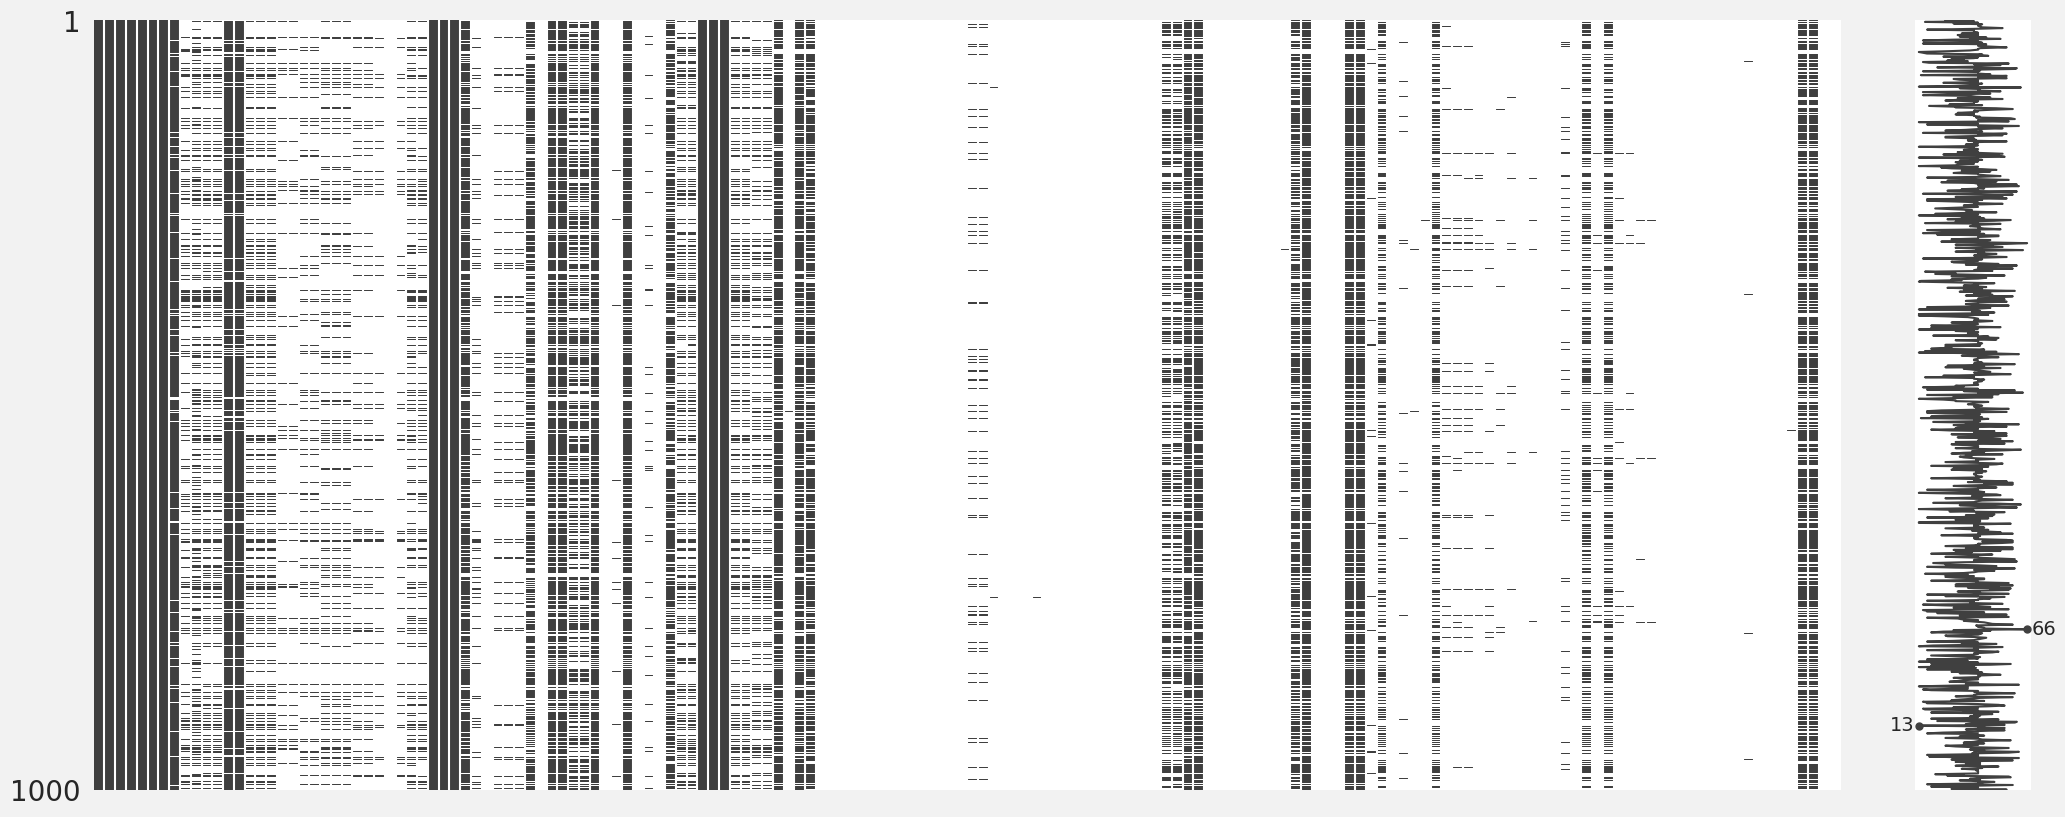

In [6]:
fig = plt.figure(figsize=(20, 10))
msno.matrix(df.sample(1000))
plt.show()

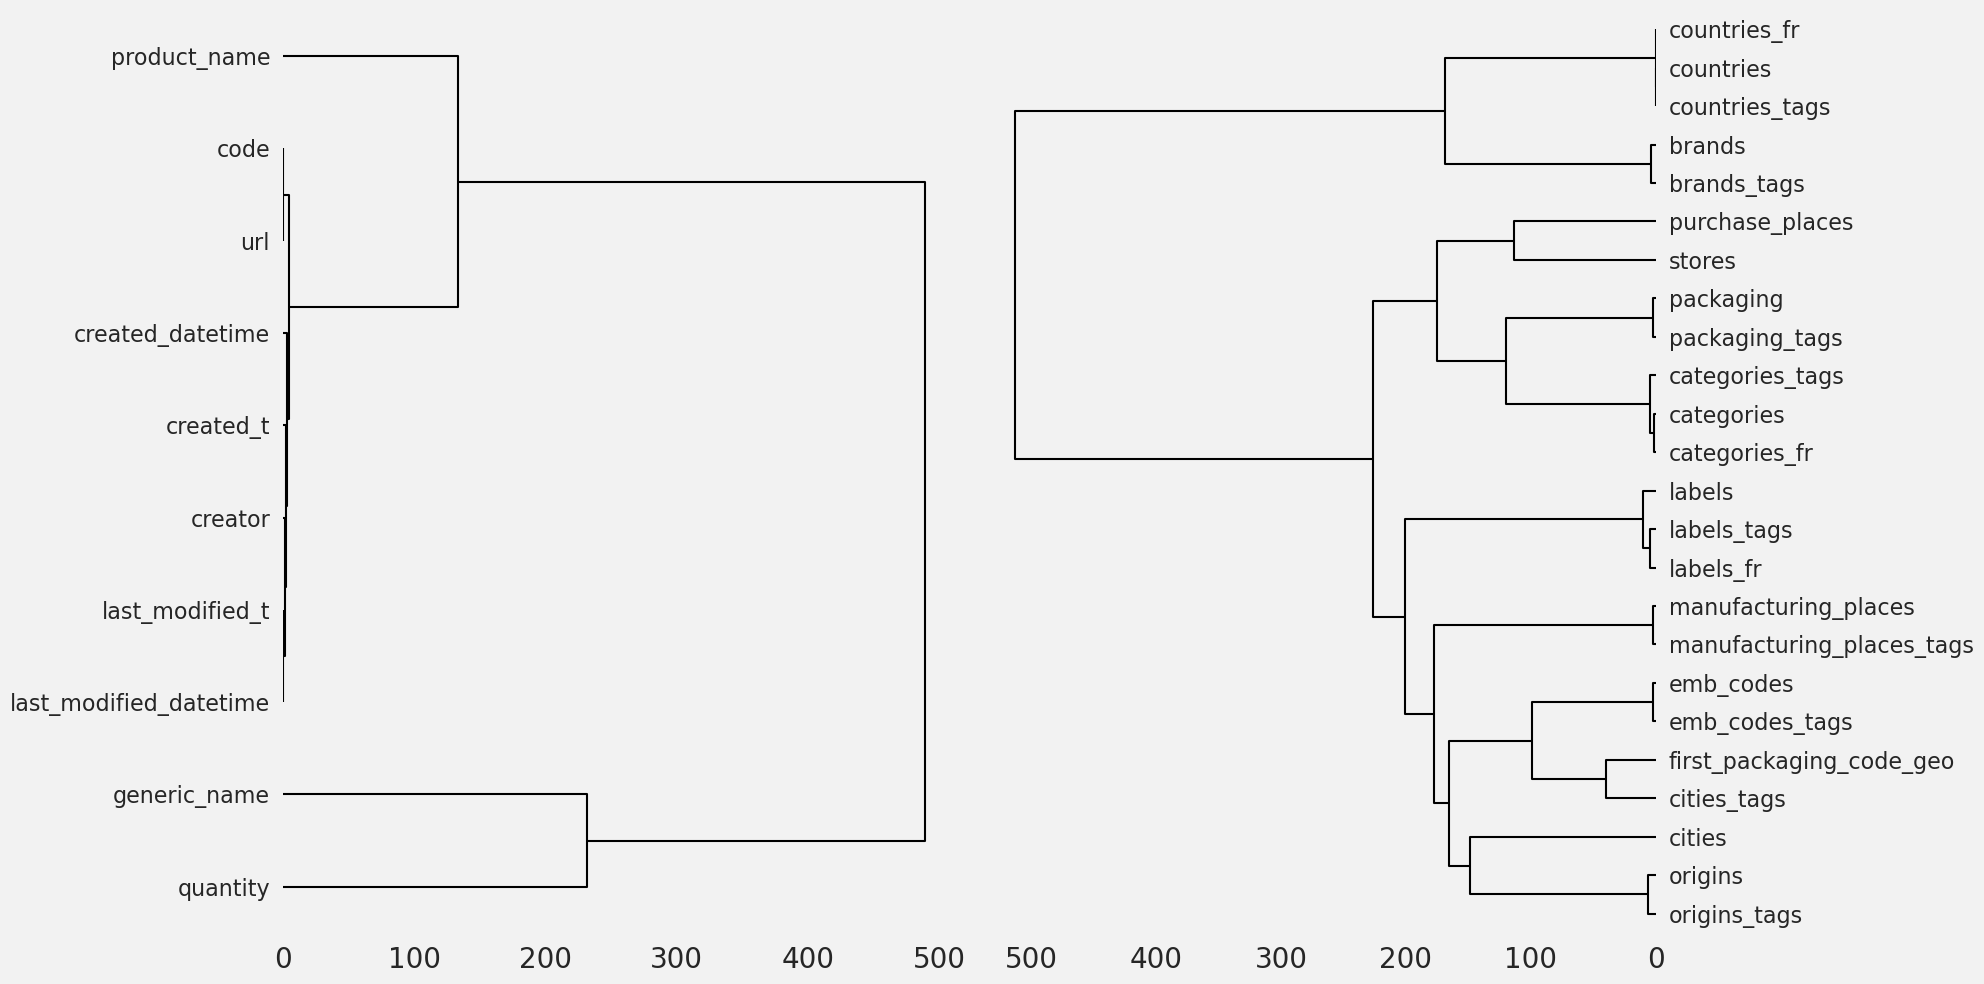

In [7]:
fig = plt.figure(figsize=(20, 10))

msno.dendrogram(df.loc[:, "code":"quantity"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "packaging":"countries_fr"], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

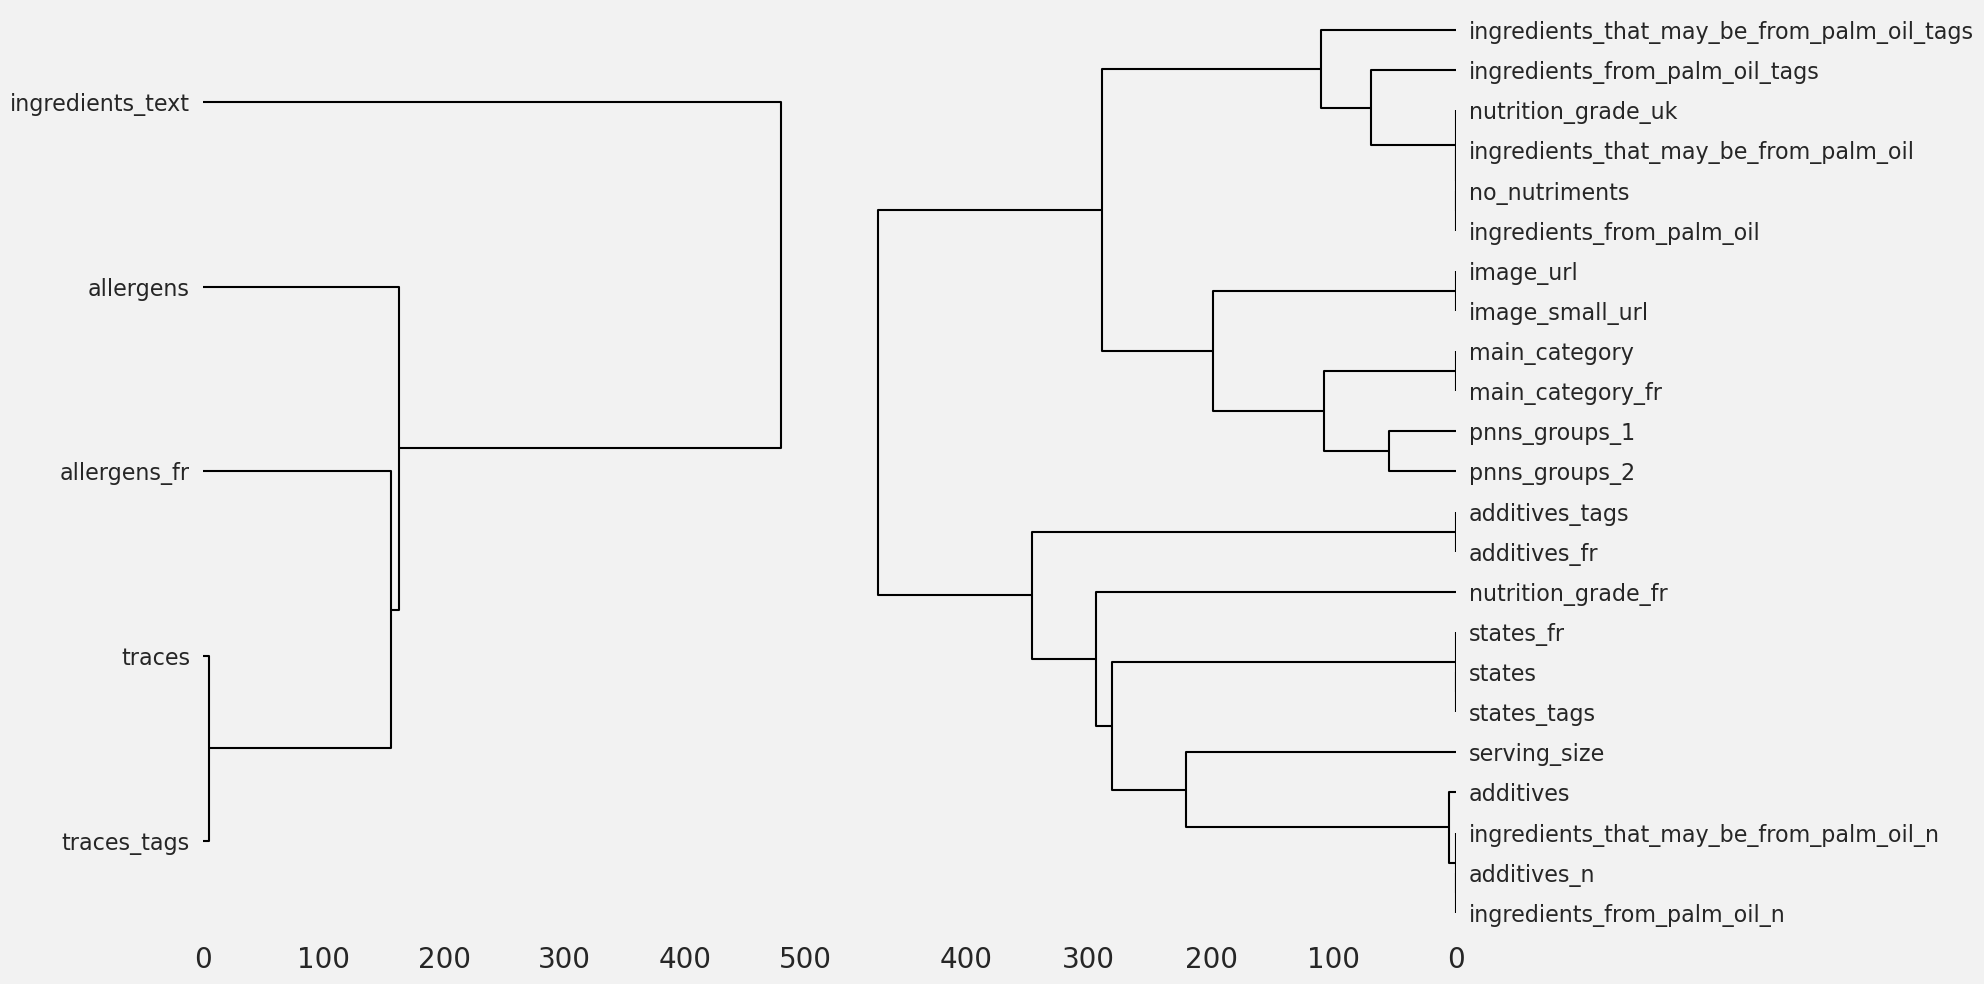

In [8]:
fig = plt.figure(figsize=(20, 10))


msno.dendrogram(df.loc[:, "ingredients_text":"traces_tags"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "serving_size":"image_small_url"], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

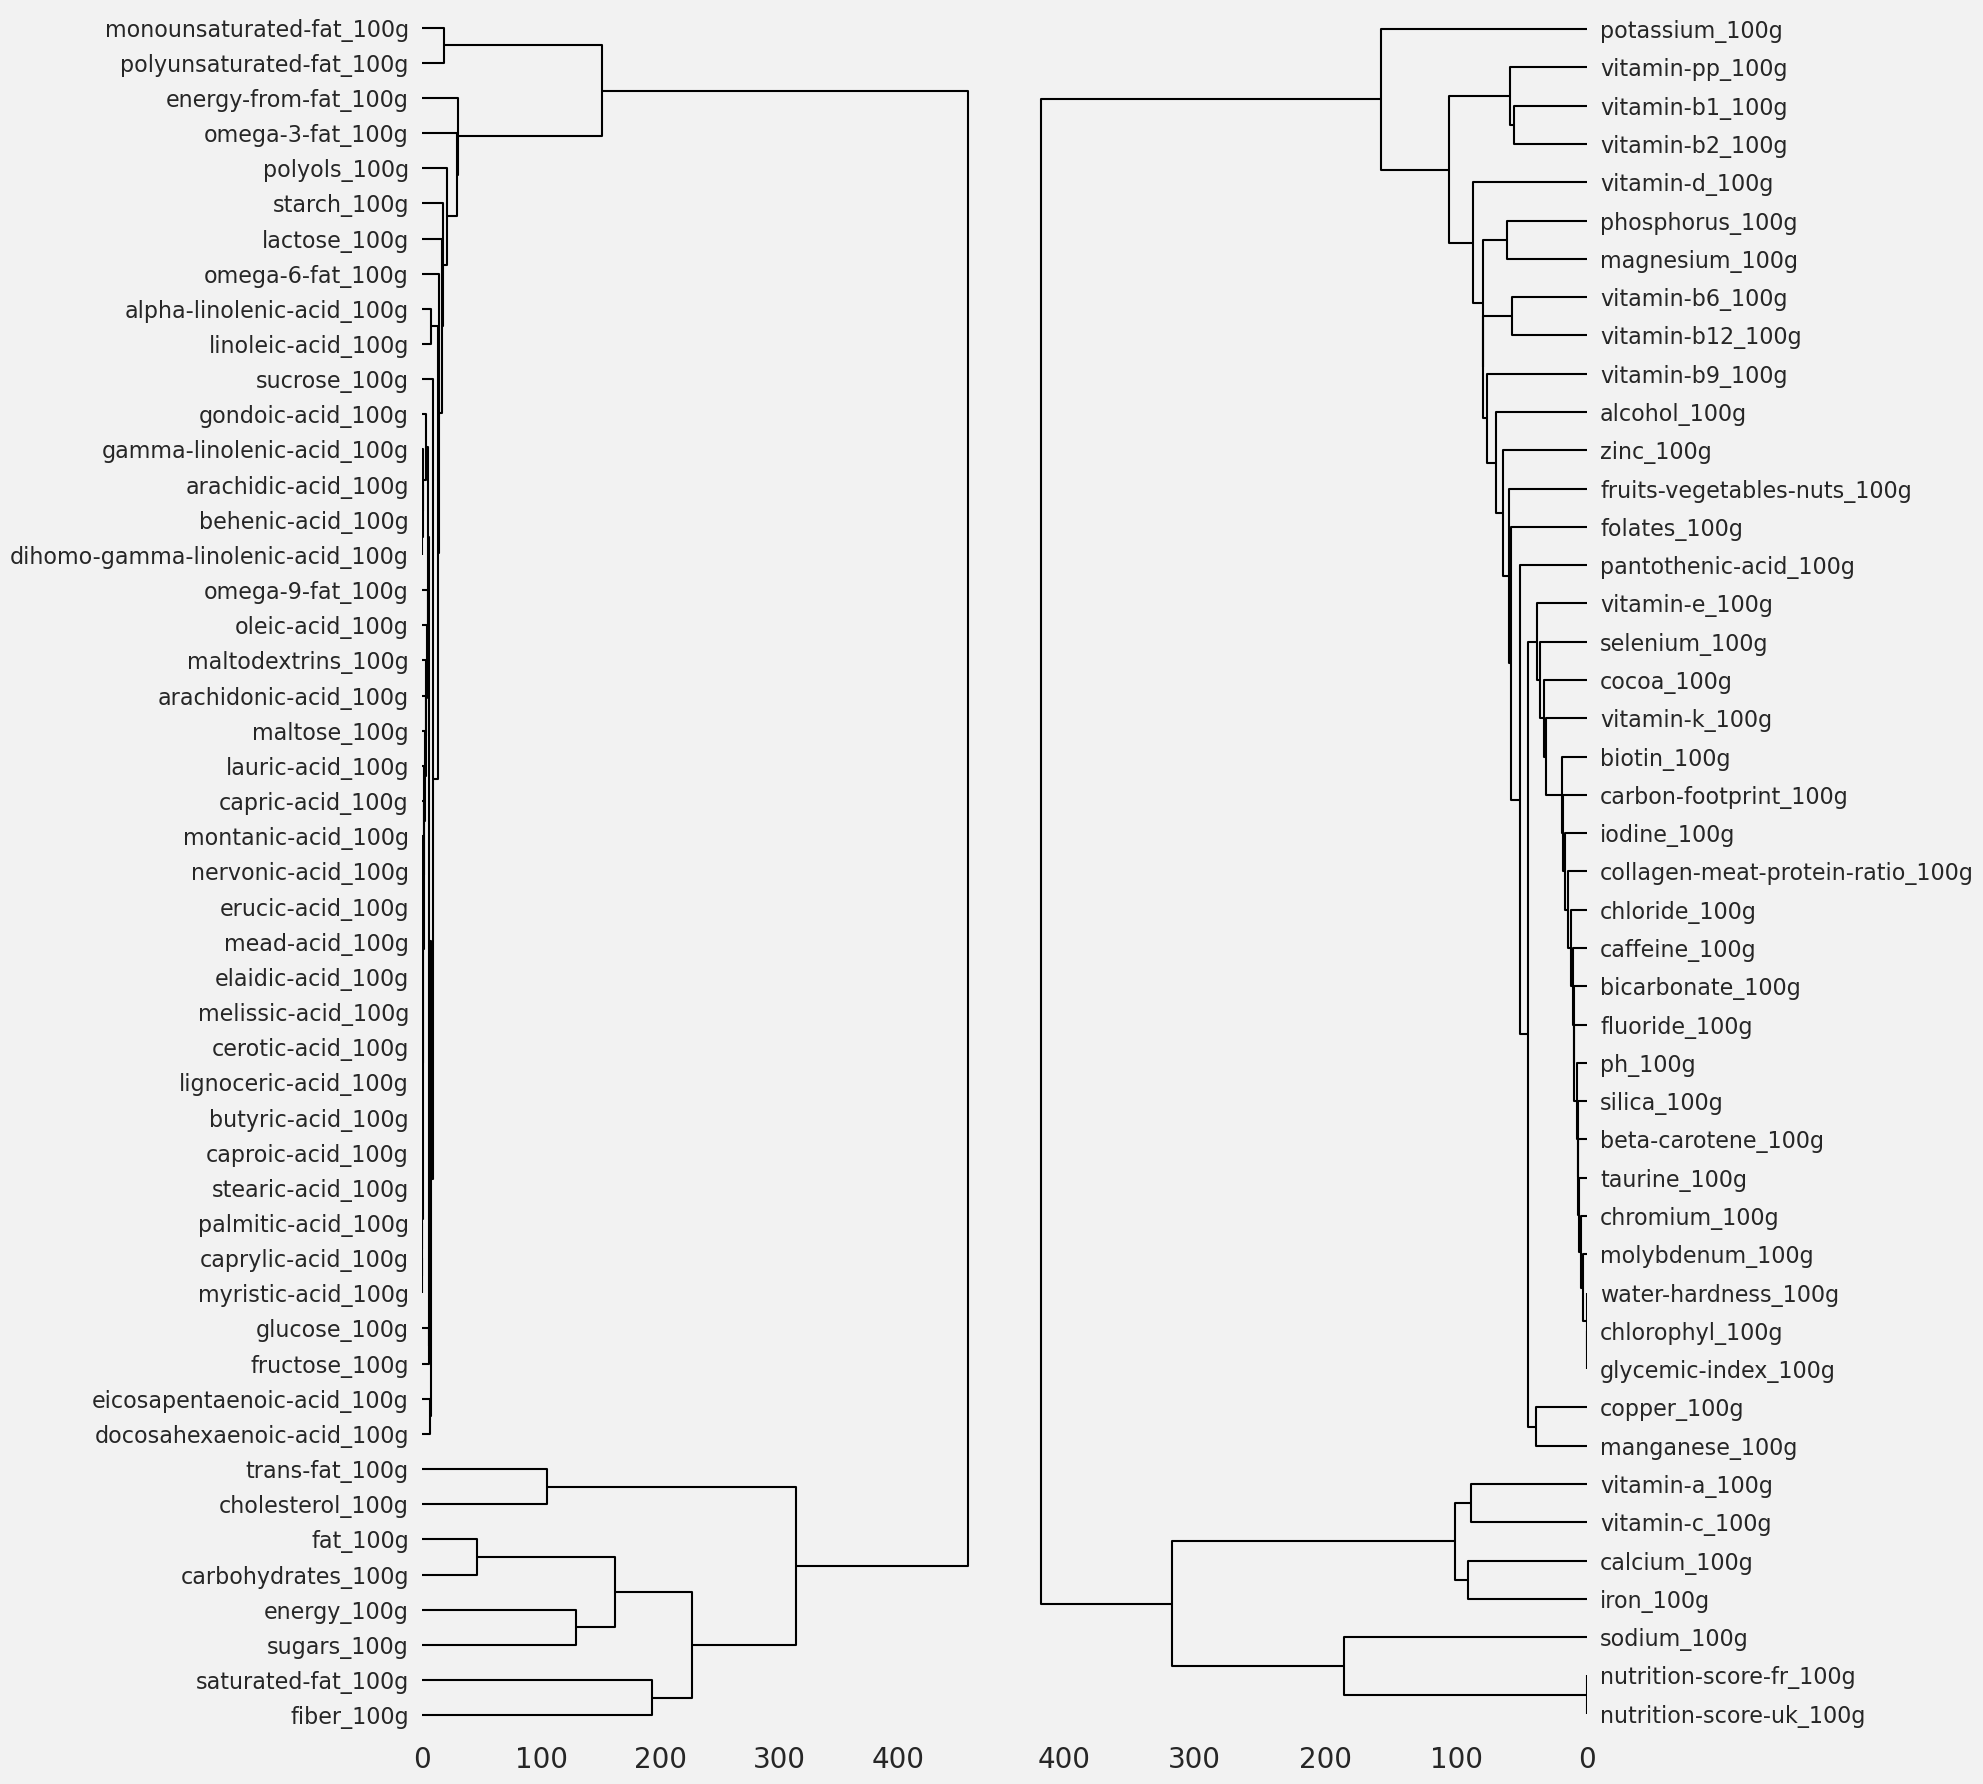

In [9]:
fig = plt.figure(figsize=(20, 18))


msno.dendrogram(df.loc[:, "energy_100g":"fiber_100g"], orientation='right', ax=fig.add_subplot(121))
msno.dendrogram(df.loc[:, "sodium_100g":], orientation='left', ax=fig.add_subplot(122))
plt.tight_layout()
plt.show()

## Classes

In [10]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, features=None, target=None):
        self.features = features
        self.target = target

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Drop rows with missing target values, select specified features and target, and drop duplicates
        X_selected = X.dropna(subset=self.target)[self.features].drop_duplicates(subset=self.features)
        y_selected = X[self.target][X_selected.index]
        return X_selected, y_selected

In [11]:
class OutlierToNaN(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.vmin = kwargs['vmin'] if 'vmin' in kwargs else None
        self.vmax = kwargs['vmax'] if 'vmax' in kwargs else None
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):   
        X_copy = X.copy()
        if self.vmin != None:
            X_copy[X < self.vmin] = np.nan
        if self.vmax != None:
            X_copy[X > self.vmax] = np.nan
        return X_copy

In [12]:
class ContinuousImputer(BaseEstimator, TransformerMixin):
    def __init__(self, dist, scaler, n_miss, *prms):
        self.dist = dist
        self.scaler = scaler
        self.n_miss = n_miss
        self.params =[p for p in prms]

    def fit(self, X, y=None):
        return self    
    
    def transform(self, X):
        missing_indices = X.index[X.isna()]
        new_data = self.dist.rvs(*self.params, size=self.n_miss)
        reverse_transform = self.scaler.inverse_transform(new_data.reshape(-1, 1)).flatten()
        imputed_series = X.copy()
        imputed_series[missing_indices] = reverse_transform
        return imputed_series

In [13]:
class CatImputer(BaseEstimator, TransformerMixin):
    def __init__(self, n_cat):
        self.n_cat = n_cat

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        # Impute missing values using a random variable
        def random_imputing(row, choices, probs):
            if pd.isnull(row):
                return np.random.choice(choices, p=probs)
            else:
                return row

        # Calculate value counts of non-null values
        vc = X.dropna().value_counts()

        # Map top categories, treat others as 'other', and calculate normalized value counts
        if len(vc) < self.n_cat:
            top = X.map({
                i: i if i in vc[:self.n_cat].index.tolist() else "misc"
                for i in vc.index.tolist()
            })
        else:
            top = X.map({
                i: i for i in vc.index.tolist() if i in vc.index.tolist()
            })

        top_vc = top.value_counts(normalize=True)

        # Extract choices and corresponding probabilities
        self.choices = top_vc.index.tolist()
        self.probs = pd.to_numeric(top_vc.values, errors="coerce")

        # Apply the imputation function to the Series
        X_imputed = top.apply(
            random_imputing,
            args=(
                self.choices,
                self.probs,
            ),
        )

        return X_imputed

In [14]:
class WordEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, rank=20):
        self.rank = rank

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        vectorizer = CountVectorizer(
            max_features=self.rank,
            binary=True,
            stop_words='english',
            token_pattern=r'\b\w{2,}\b',
            strip_accents='ascii'
        )
        X_vectorized = X.copy()
        print(len(X))
        vectors = vectorizer.fit_transform(X.dropna()).toarray()
        print('len vector', len(vectors))
        missing_indices = X_vectorized[X.isna()].index
        print('len X ok', len(X_vectorized[~X.index.isin(missing_indices)]))
        X_vectorized[~X.index.isin(missing_indices)] = vectors
        X_vectorized = X_vectorized.fillna(pd.Series(np.full(self.rank, np.nan)))
        print('ok')
        return X_vectorized

In [15]:
class WordImputer(BaseEstimator, TransformerMixin):
    def __init__(self, to_impute=None):
        self.to_impute = to_impute

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        knn = KNNImputer(n_neighbors=10)
        imputed_col = knn.fit(X[self.to_impute])
        X.loc[:, self.target] = imputed_col
        return X

## Definition of Features and Target

In [16]:
target = "main_category"

feats = [
    "creator",
    "ingredients_text",
    "countries_tags",
    "brands",
    "nutrition-score-uk_100g",
    "saturated-fat_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "energy_100g",
]

## Univariate Analysis

### Features Selection and Filtering

In [17]:
fs = FeatureSelector(features=feats, target=target)

X_, y_ = fs.fit_transform(df)

vmin_nutrition_score = X_['nutrition-score-uk_100g'].min()
vmax_nutrition_score = X_['nutrition-score-uk_100g'].max()
vmin_ = 0.000_000_1
vmax_ = 100
vmax_energy = 5000


for c in [col for col in X_.columns if str(X_[col].dtype).startswith('float')]:
    if c.startswith('nutrition-score'):
        vmin, vmax = vmin_nutrition_score, vmax_nutrition_score
    elif c.startswith('energy'):
        vmin, vmax = vmin_, vmax_energy
    else:
        vmin, vmax = vmin_, vmax_
        
    vmax = vmax_energy if c.startswith('energy') else vmax_
    otn = OutlierToNaN(vmin=vmin, vmax=vmax)
    X_.loc[:, c] = otn.fit_transform(X_[c])

    print(f'{X_[c].name}:\n- min = {X_[c].min()}\n- max = {X_[c].max()}\n')

nutrition-score-uk_100g:
- min = -15.0
- max = 35.0

saturated-fat_100g:
- min = 0.0001
- max = 100.0

sugars_100g:
- min = 0.0001
- max = 100.0

proteins_100g:
- min = 0.0001
- max = 100.0

salt_100g:
- min = 1e-06
- max = 100.0

energy_100g:
- min = 0.02
- max = 4975.0



In [18]:
X_.shape

(80561, 10)

In [19]:
def occurences(df, cats, pos=0, fig=None):
    if not fig:
        fig = plt.figure(figsize=(6 * len(cats), 8))
        
    for i, cat in enumerate(cats):
        ax = fig.add_subplot(1, pos + len(cats), pos + i + 1)
        values_once = df[cat].value_counts() == 1
        values_twice = df[cat].value_counts() == 2
        non_outliers = ~(values_once | values_twice)
        labels = ["More than twice", "Twice", "Once"]
        sizes = [sum(non_outliers), sum(values_twice), sum(values_once)]

        plt.pie(
            sizes,
            labels=labels,
            autopct="%1.1f%%",
            colors=sns.color_palette("pastel")
        )
        plt.title(f'Categories occurrence in "{cat}"')
    plt.tight_layout()
    plt.show()

n_missing = lambda series: len(series.index) - series.count()

Text(0, 0.5, '')

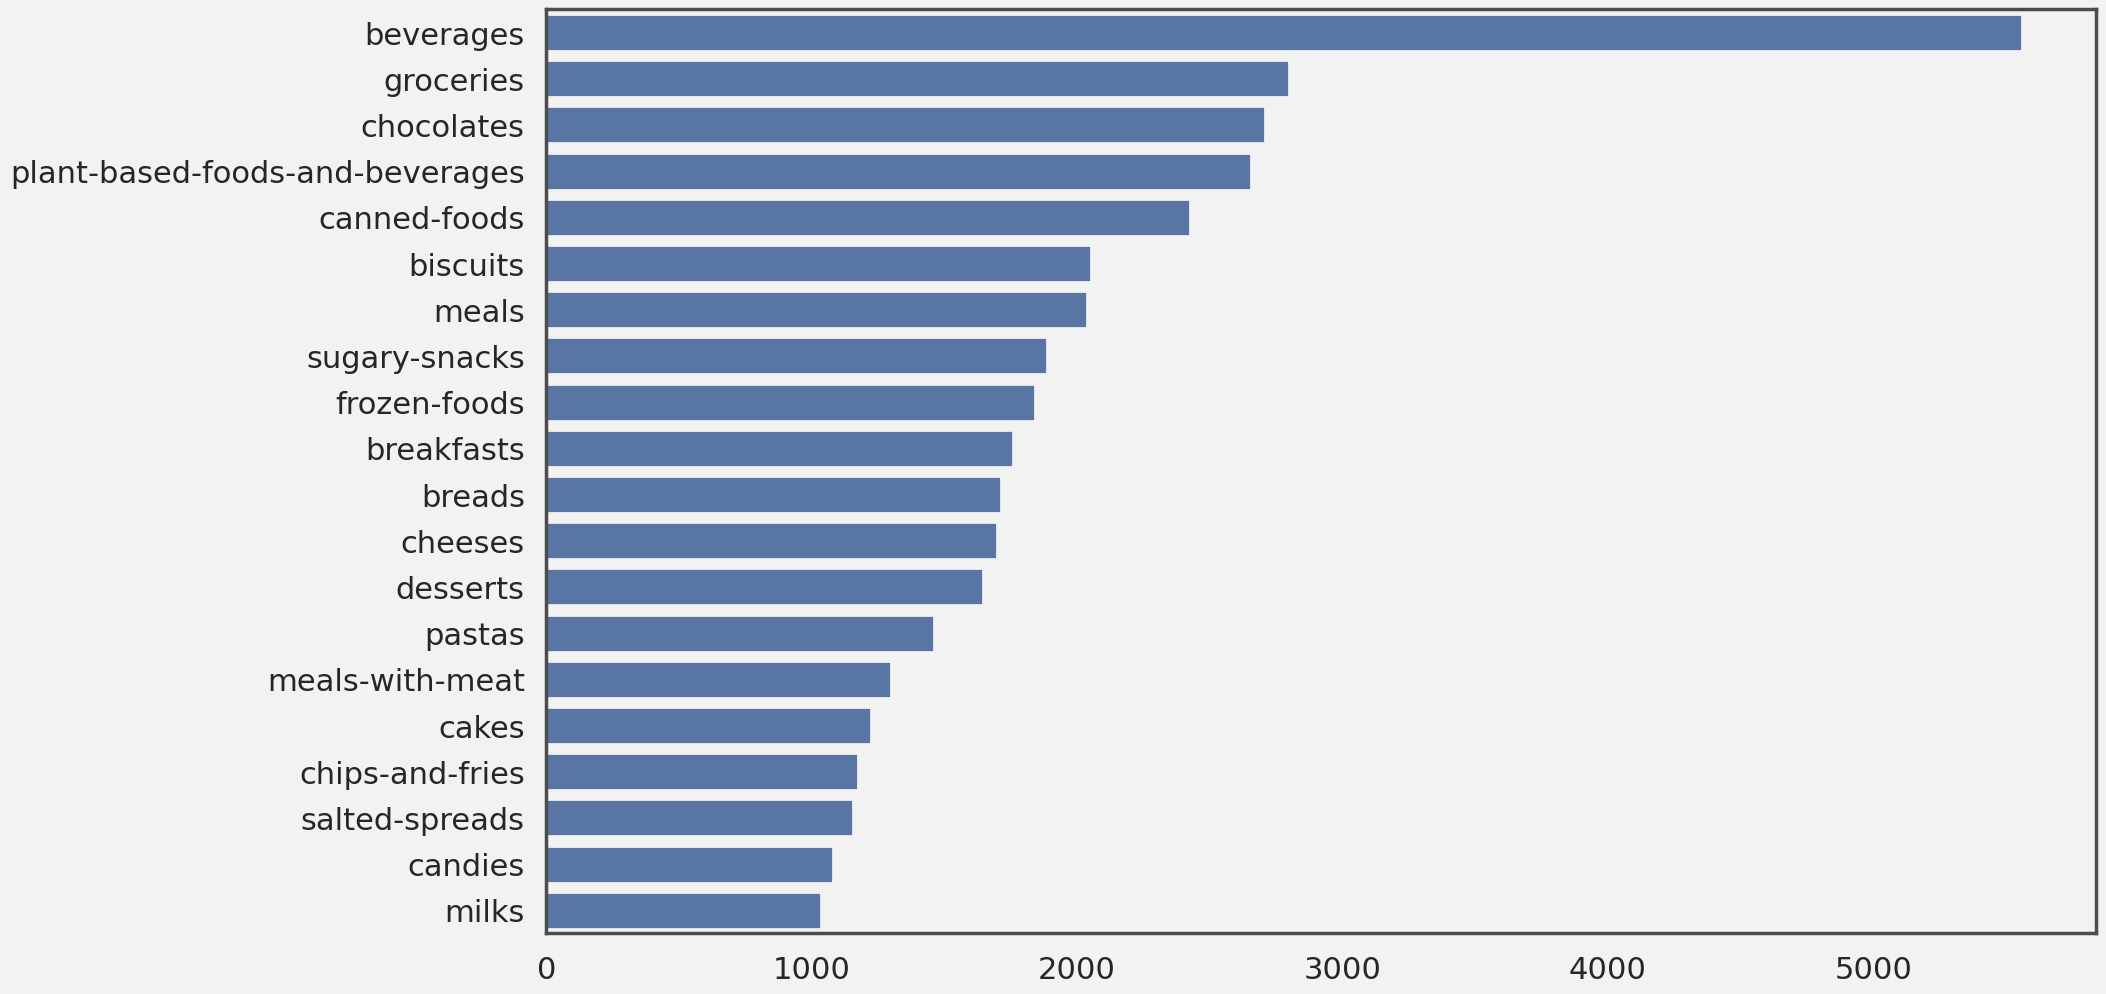

In [20]:
fig = plt.figure(figsize=(20, 12))
sns.set_context('poster')
sns.countplot(
    y=y_.str.replace('en:', ''),
    order=y_.value_counts()[:20].index.str.replace('en:', ''),
    color='b'
)
plt.xlabel("")
plt.ylabel("")


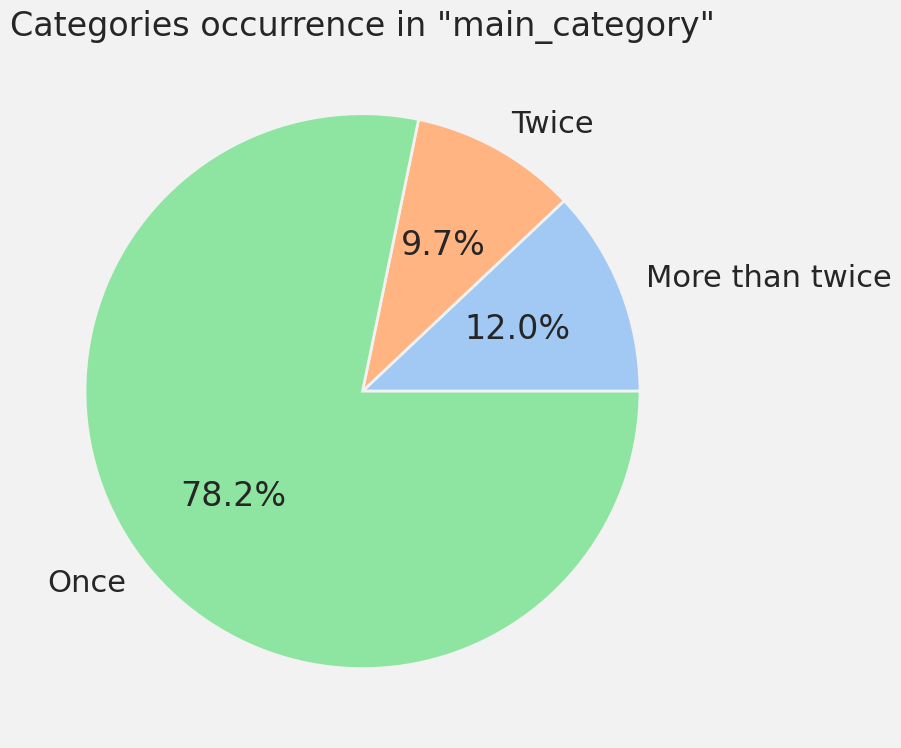

In [21]:
fig = plt.figure(figsize=(20, 8))
occurences(pd.DataFrame(y_), [target], pos=1, fig=fig)

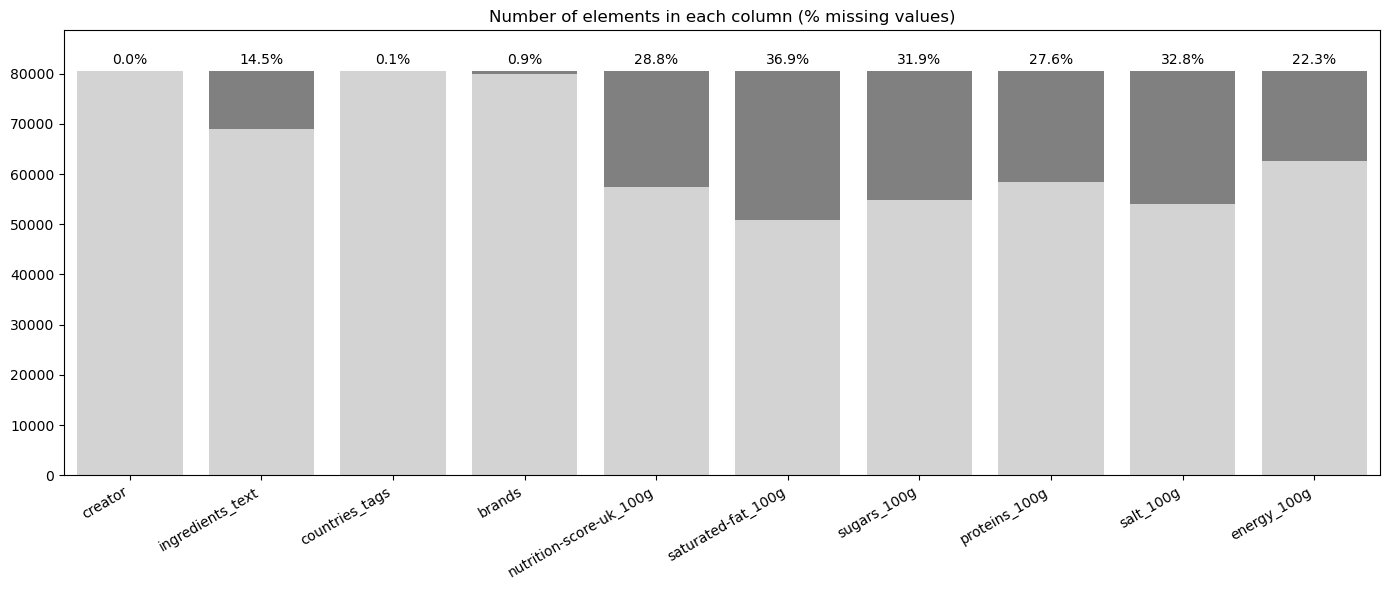

In [21]:
sns.reset_orig()
fig = plt.figure(figsize=(14, 6))

# Bars of the number of products with a non-null target value
bar_total = sns.barplot(
    x=X_.count().index, y=[len(X_)] * len(X_.count()), color="gray"
)

# Bars of the number of products with non-null values for each feature
bar_elements = sns.barplot(
    x=X_.count().index, y=X_.count().values, color="lightgray"
)

# Plot of the superposed bars with the percentage of values missing
for i, col in enumerate(X_.columns):
    bar_total.text(
        i,
        1.01 * len(X_),
        f"{round(n_missing(X_[col]) / len(X_) * 100, 1)}%",
        ha="center",
        va="bottom",
        color="black",
    )

bar_total.set_ylim(0, 1.1 * len(X_))
plt.xticks(rotation=30, ha="right")
plt.title("Number of elements in each column (% missing values)")
plt.tight_layout()
plt.show()
sns.set_style("white")

### Categorical Features

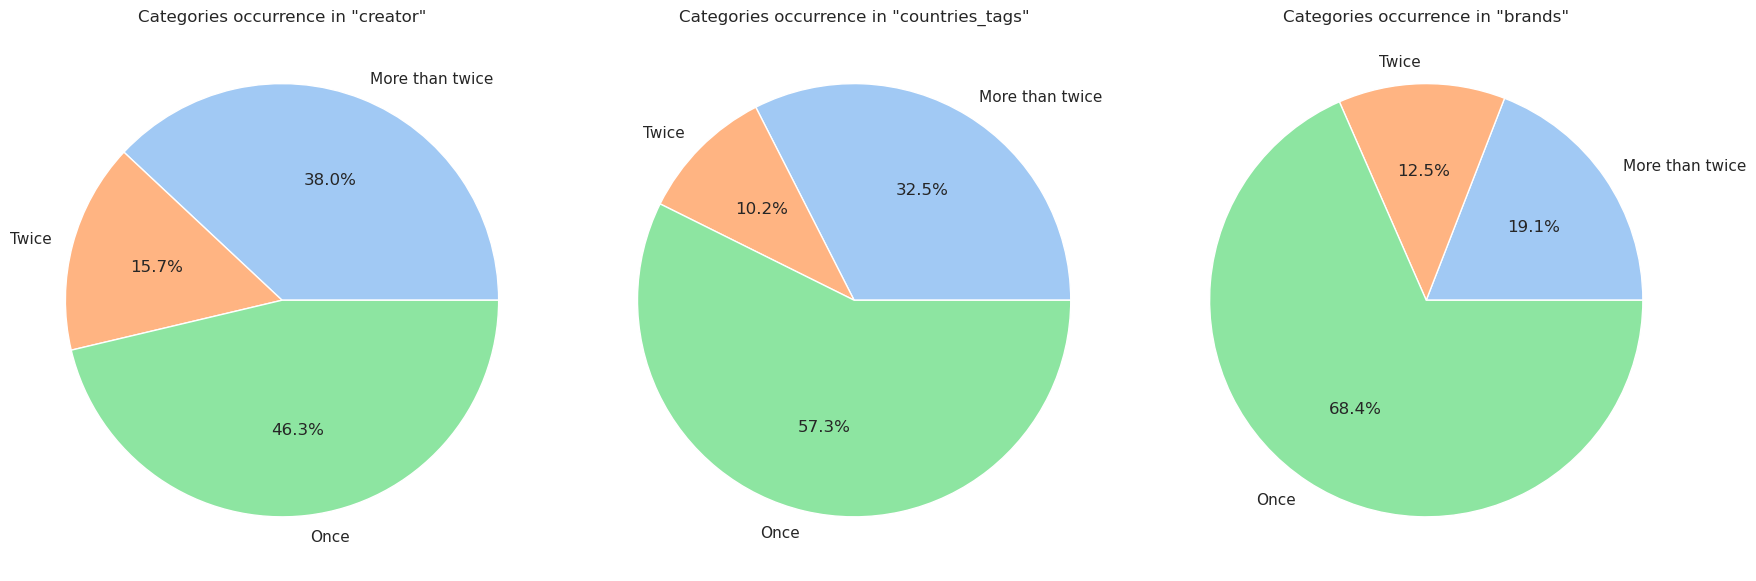

In [24]:
# List of features with values equal to unique words
list_cat = ['creator', 'countries_tags', 'brands']

# For each feature, classify the values by number of occurences in the data 
occurences(X_, list_cat)

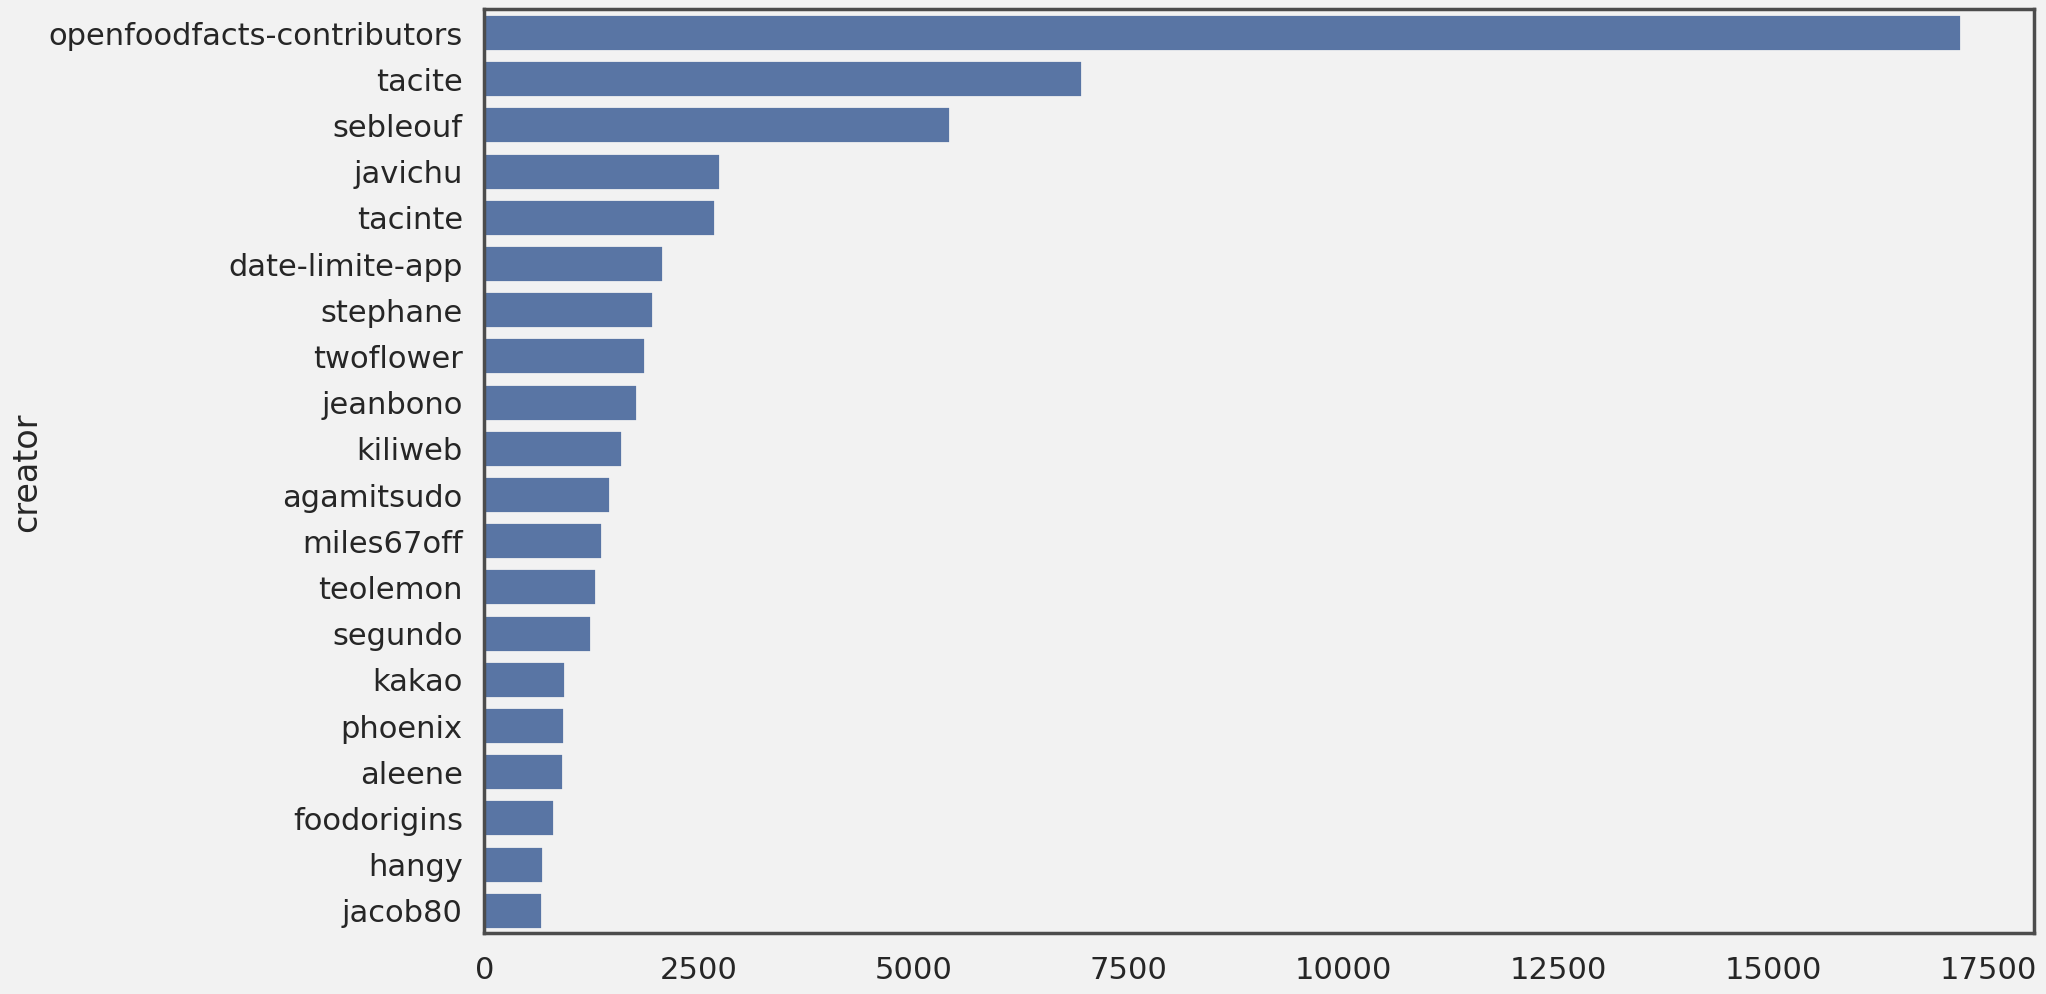

In [30]:
sns.set_context('poster')
fig = plt.figure(figsize=(20,12))
cat_imp = CatImputer(20)
X_imputed = cat_imp.fit_transform(X_['creator'])

sns.barplot(x = cat_imp.fit_transform(X_['creator']).value_counts().values[:20], y=X_['creator'].value_counts().index[:20], color='r')
sns.barplot(x = X_['creator'].value_counts().values[:20], y=X_['creator'].value_counts().index[:20], color='b')

plt.show()

In [37]:
# Gather the numerical features with their value in a dict
numerical_data_100g = {
    feat: X_[feat][~X_[feat].isna()] 
    for feat in ["sugars_100g", "saturated-fat_100g", "proteins_100g", "salt_100g"]
}

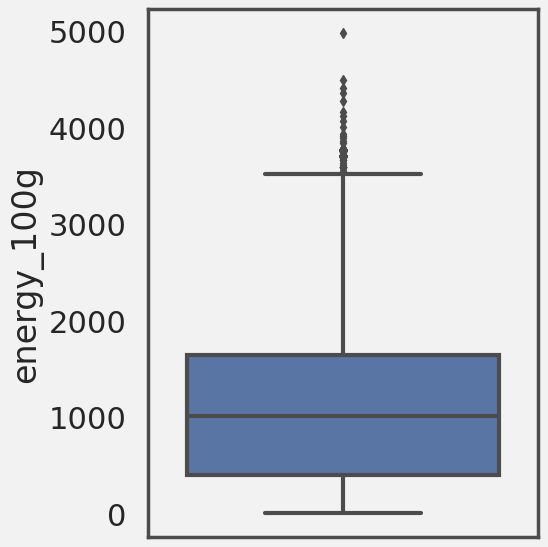

In [47]:
sns.set_context('poster')
fig = plt.figure(figsize=(6, 6))

# Filter out the energy values > 4000 kcal/100g
bounded_energy = X_["energy_100g"][
    (X_["energy_100g"] > 0) & (X_["energy_100g"] <= 4000)
]

sns.boxplot(y=X_["energy_100g"])
plt.tight_layout()
plt.savefig("../../open_food_facts_plots/test.png",bbox_inches='tight')
plt.show()

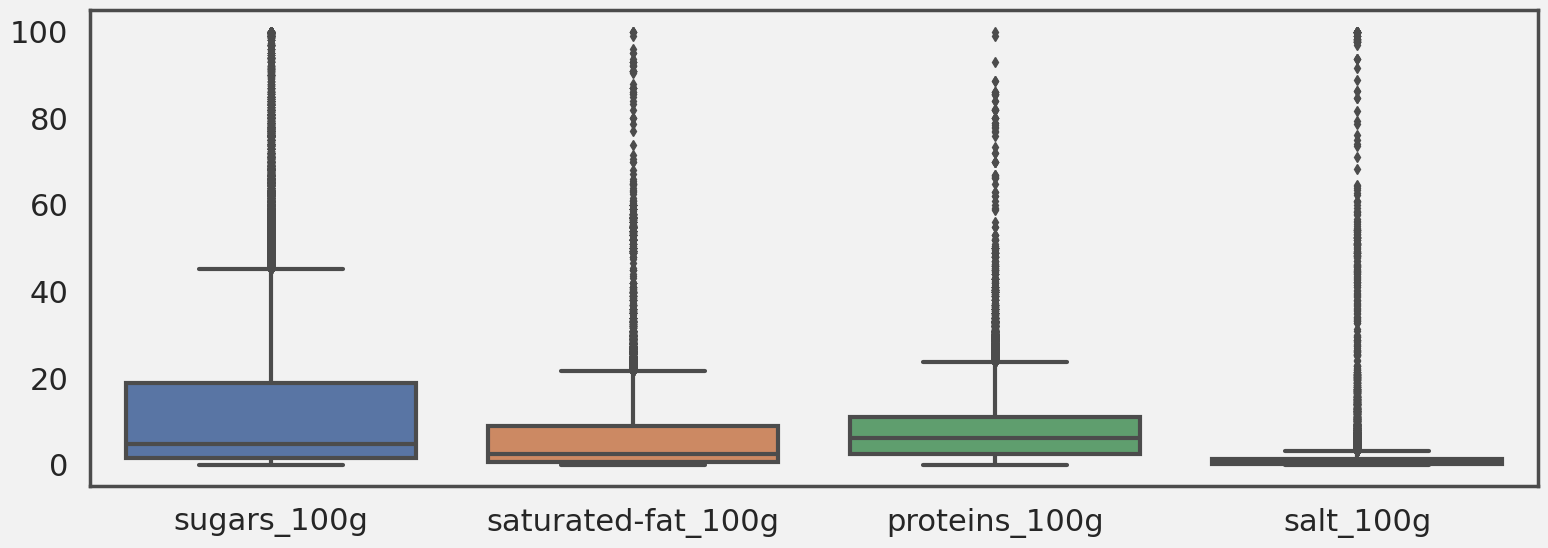

In [46]:
fig = plt.figure(figsize=(16, 6))

# Plot one boxplot for each numerical feature
sns.boxplot(data=pd.DataFrame.from_dict(numerical_data_100g))
plt.tight_layout()
plt.savefig("../../open_food_facts_plots/test2.png",bbox_inches='tight')
plt.show()

In [51]:
from scipy.stats import norm, halfgennorm, f_oneway, probplot
from sklearn.preprocessing import scale

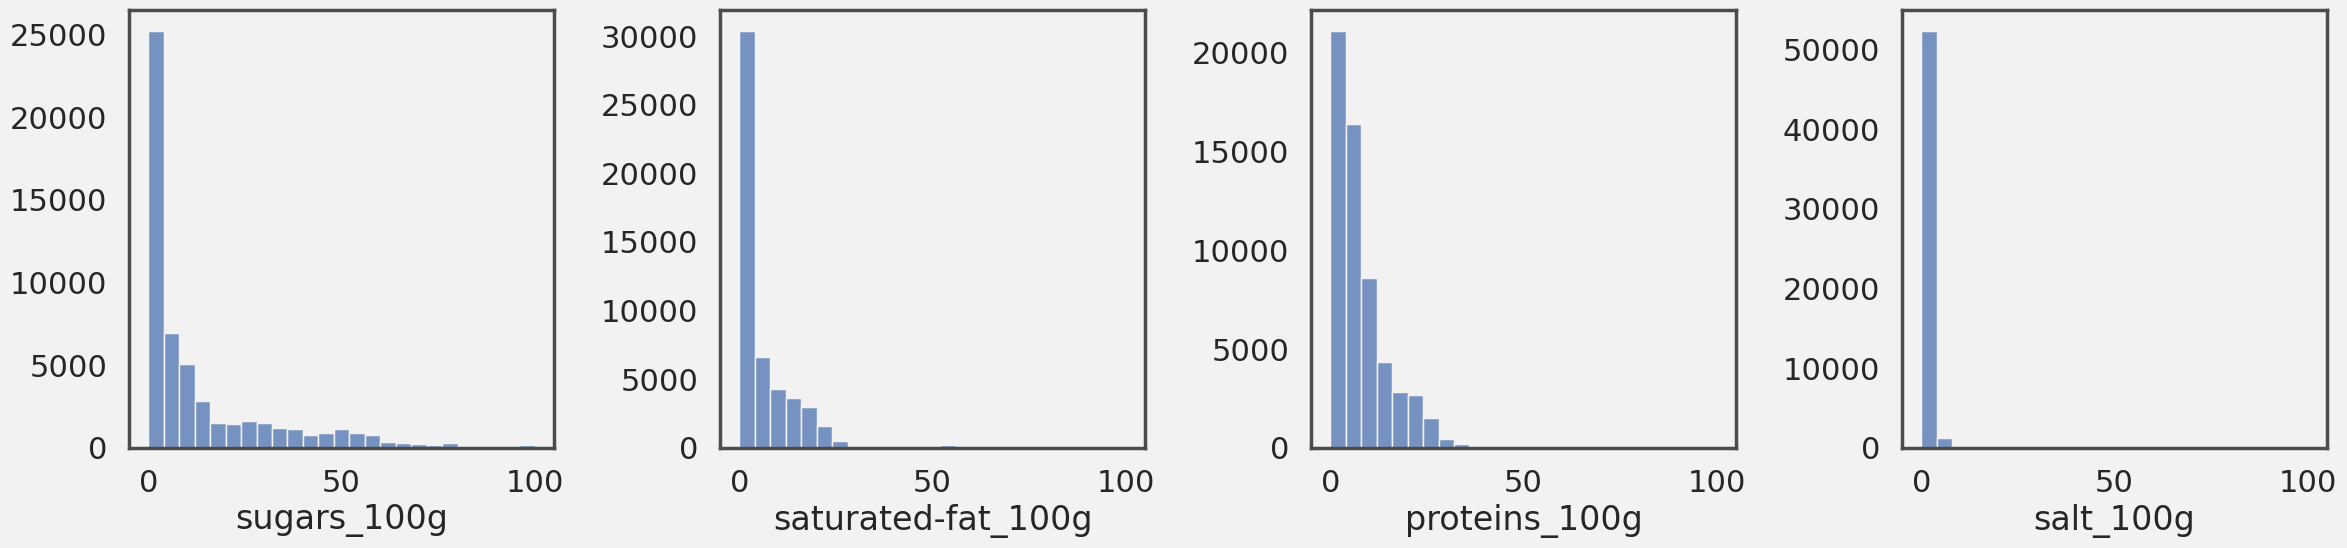

In [49]:
sns.set_context('poster')
fig = plt.figure(figsize=(24, 6))

# Plot one histogram for each numerical feature
for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(1, len(numerical_data_100g), i + 1)
    sns.histplot(numerical_data_100g[label], bins=25)
    plt.ylabel("")

plt.tight_layout()
plt.show()

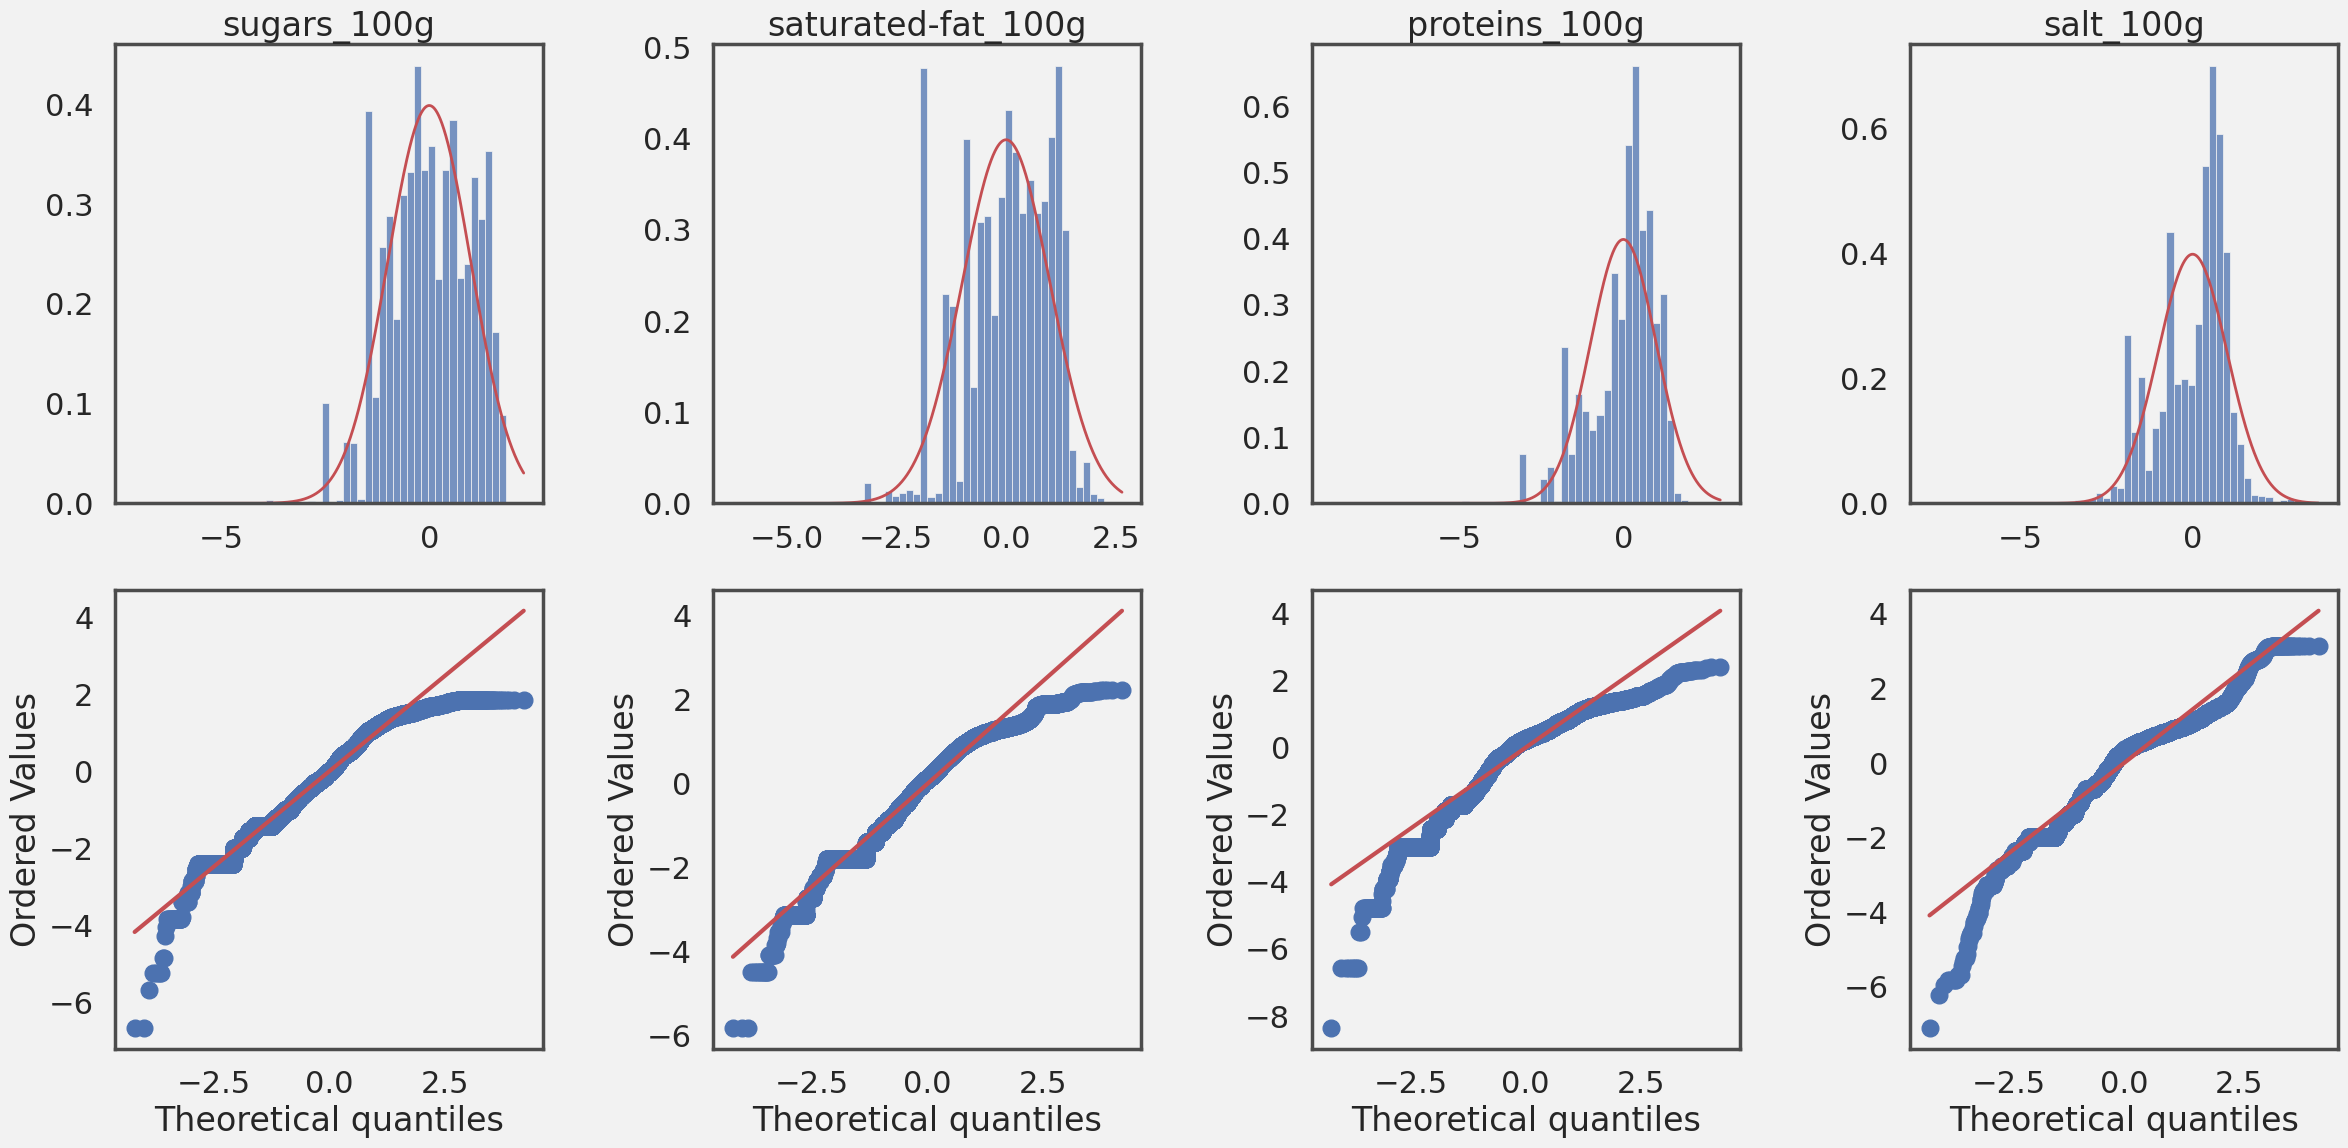

In [83]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

sns.set_context('poster')
fig = plt.figure(figsize=(24, 12))

for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(2, len(numerical_data_100g), i + 1)

    log_data = numerical_data_100g[label].apply(np.log).to_numpy().reshape(-1, 1)
    scaled_data = scaler.fit_transform(log_data).flatten()
    sns.histplot(scaled_data, bins=50, stat="density")
    plt.ylabel('')

    xmin, xmax = plt.xlim()
    x_values = np.linspace(xmin, xmax, 1000)
    params = norm.fit(scaled_data)
    n_prob = norm.pdf(x_values, *params)
    plt.plot(x_values, n_prob, "r", linewidth=2)
    plt.title(label)

    probplot(scaled_data, dist=norm, plot=fig.add_subplot(2, len(numerical_data_100g), i + 5))
    plt.title('')
plt.tight_layout()
plt.show()

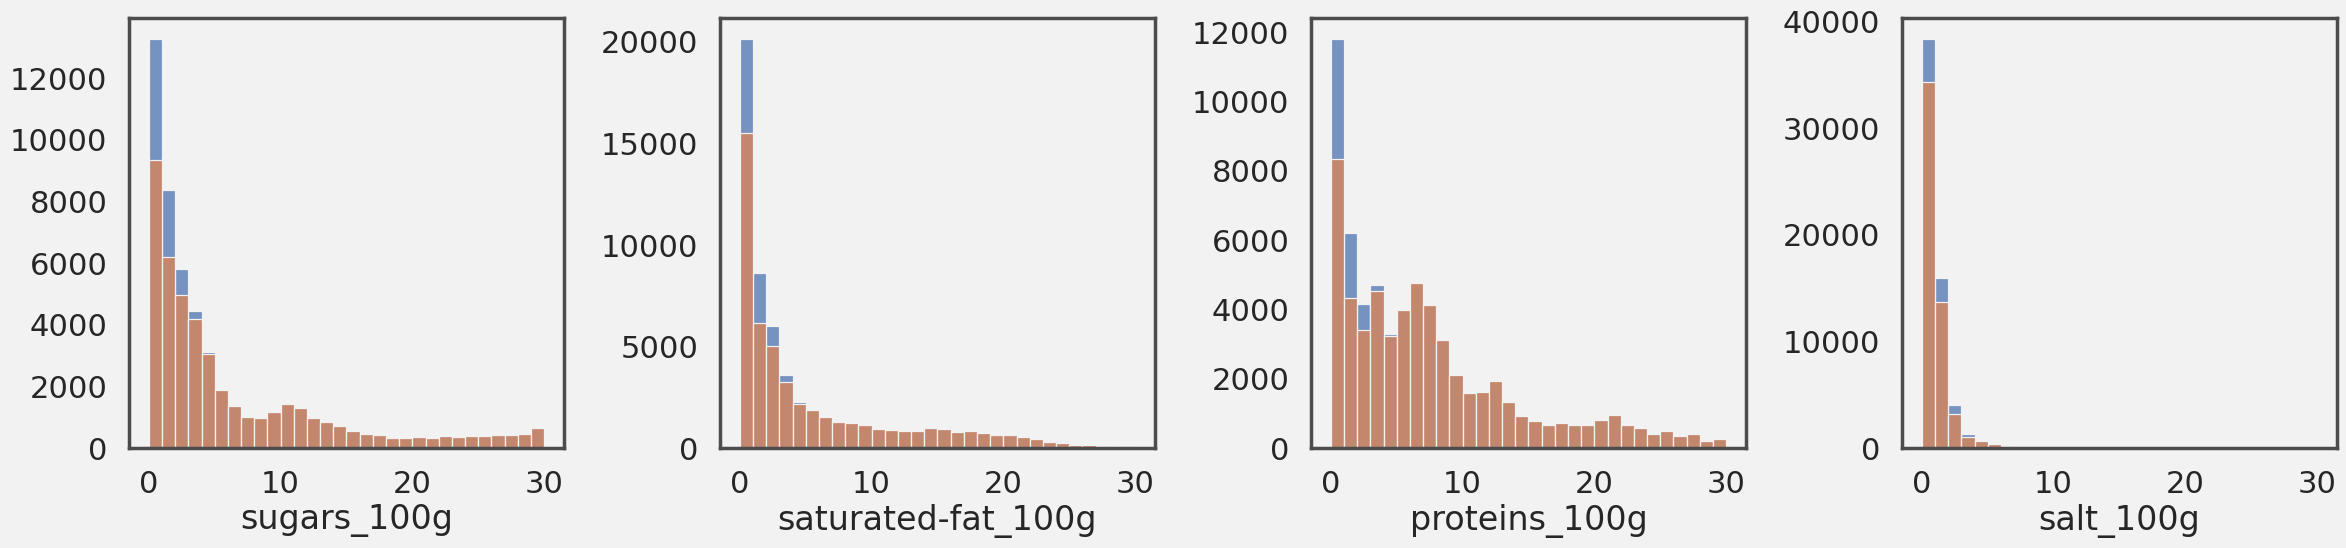

In [86]:
sns.set_context('poster')
fig = plt.figure(figsize=(24, 6))

for i, label in enumerate(numerical_data_100g):
    fig.add_subplot(1, 4, i + 1)
    n_miss = n_missing(X_[label])
    c_imp = ContinuousImputer(norm, scaler, n_miss, *params)
    imputed_series = c_imp.fit_transform(X_[label])
    
    sns.histplot(imputed_series, bins=30, binrange=[0, 30])
    sns.histplot(X_[label], bins=30, binrange=[0, 30])
    plt.ylabel('')
plt.tight_layout()
plt.show()


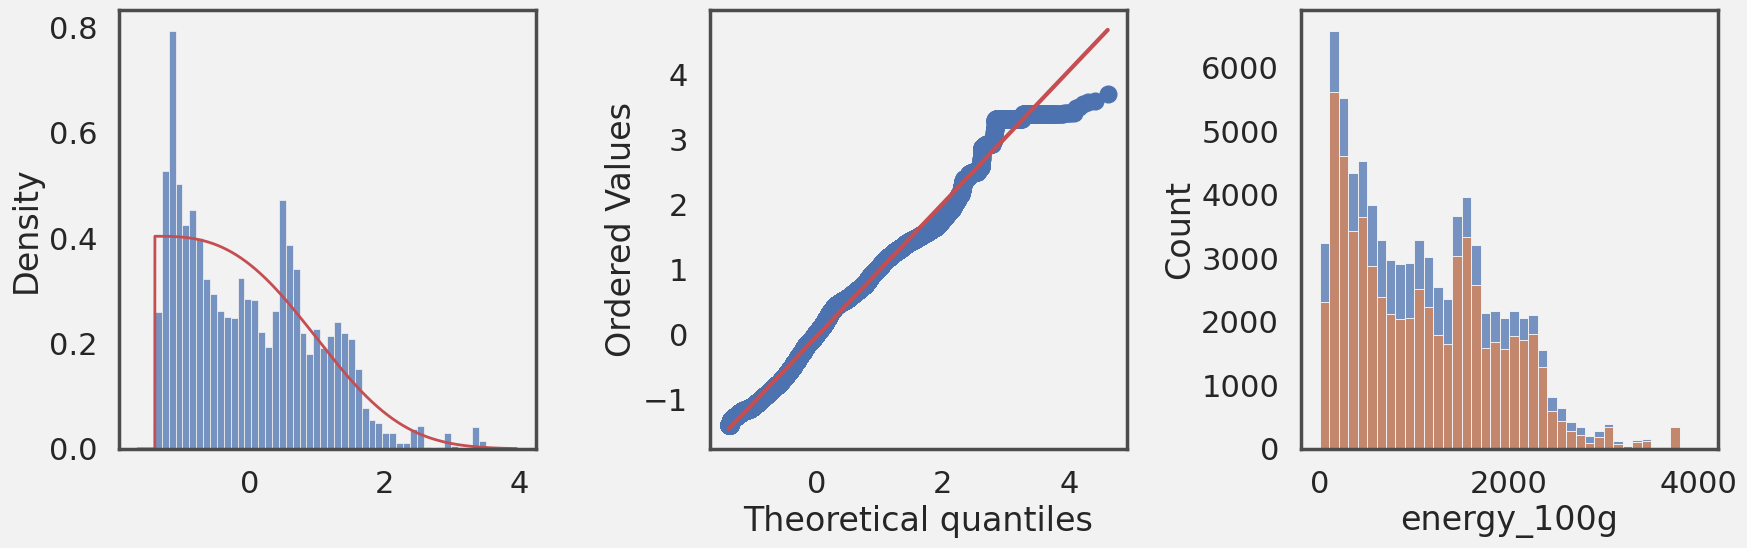

In [93]:
scaler_energy = StandardScaler()

dist = halfgennorm

sns.set_context('poster')
fig = plt.figure(figsize=(18, 6))

# Histogram and fitted distribution (halfgennorm)
fig.add_subplot(131)
scaled_energy = scaler_energy.fit_transform(bounded_energy.to_numpy().reshape(-1, 1)).flatten()
sns.histplot(scaled_energy, stat="density", bins=50)
xmin, xmax = plt.xlim()
x_values = np.linspace(xmin, xmax, 100000)
params_energy = dist.fit(scaled_energy)
n_prob = dist.pdf(x_values, *params_energy)
plt.plot(x_values, n_prob, "r", linewidth=2)

# Q-Q plot
probplot(scaled_energy, sparams=(*params_energy, ), dist=dist, plot=fig.add_subplot(132))
plt.title('')

# Plot with imputed value
fig.add_subplot(133)
n_miss_energy = n_missing(X_['energy_100g'])
c_imp = ContinuousImputer(dist, scaler_energy, n_miss_energy, *params_energy)
imputed_energy = c_imp.fit_transform(X_['energy_100g'])
sns.histplot(imputed_energy, bins=40, binrange=[0, 4000])
sns.histplot(X_['energy_100g'], bins=40, binrange=[0, 4000])

plt.tight_layout()
plt.show()

### Distribution Nutrition Score

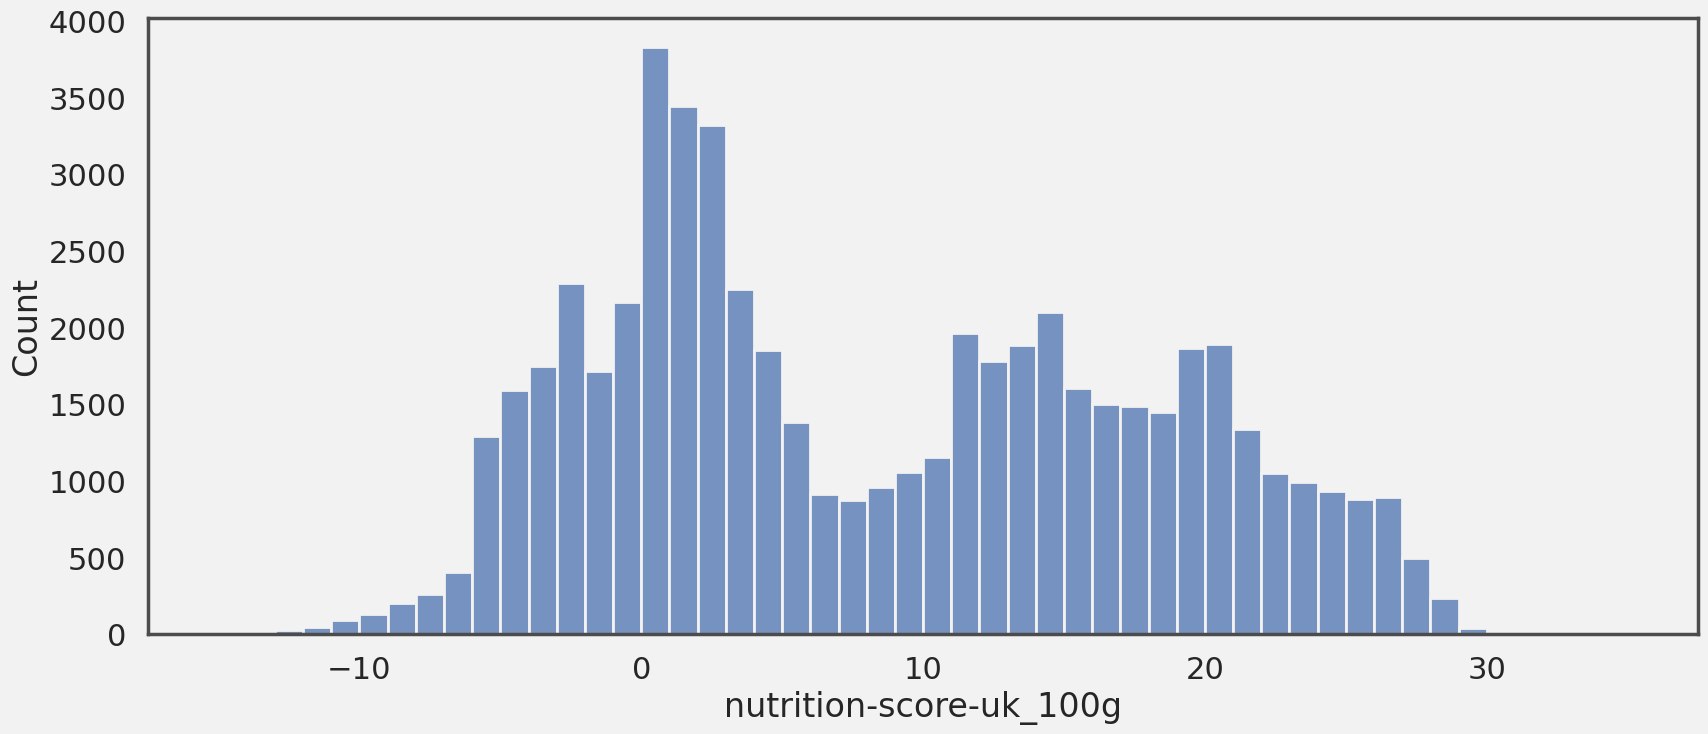

In [94]:
sns.set_context()
fig = plt.figure(figsize=(20, 8))

sns.histplot(X_['nutrition-score-uk_100g'], bins=50)

plt.show()

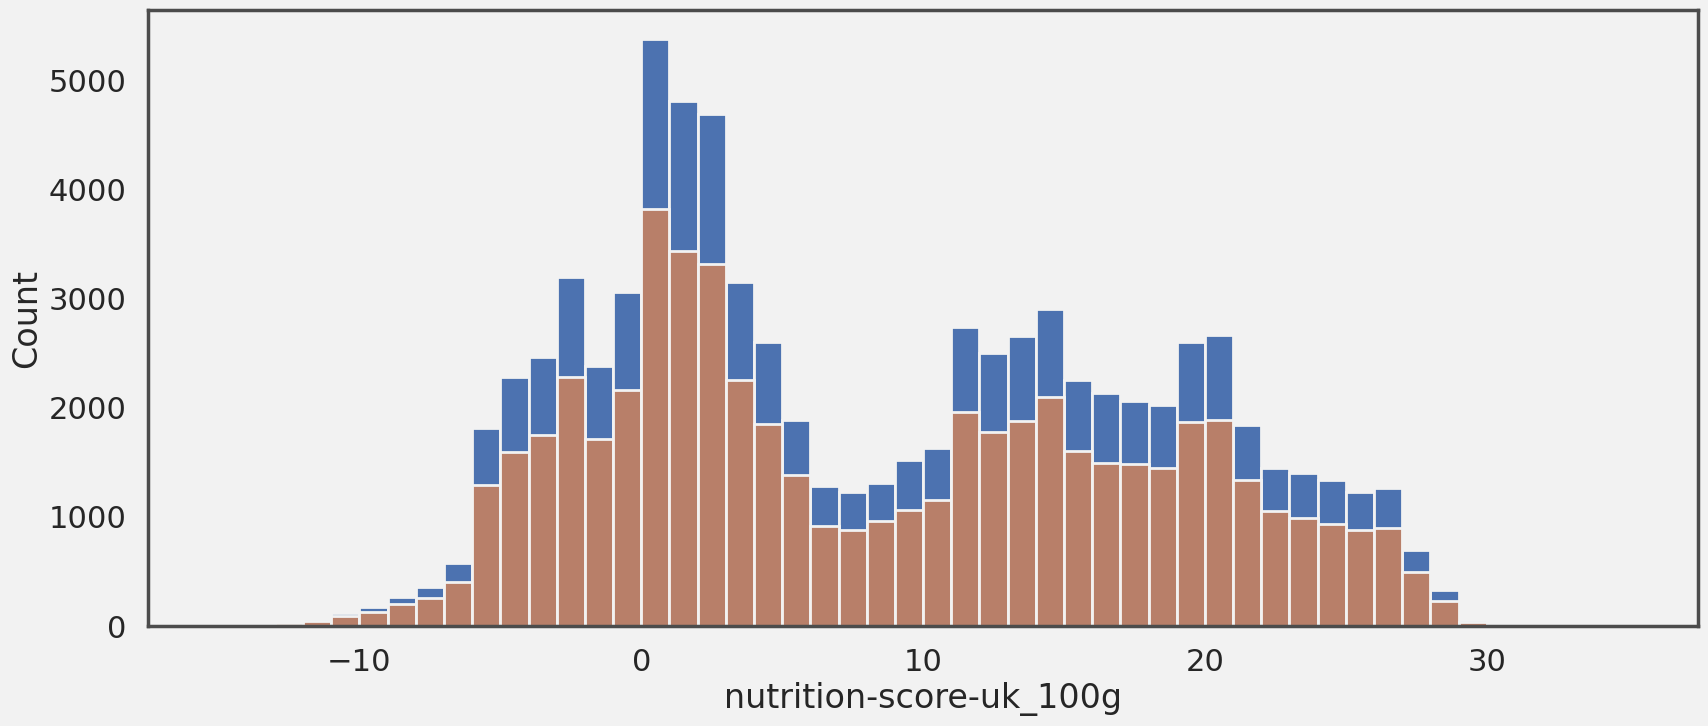

In [96]:
sns.set_context('poster')
score_imputer = CatImputer(X_['nutrition-score-uk_100g'].nunique())

imputed_scores = score_imputer.fit_transform(X_['nutrition-score-uk_100g'])

fig = plt.figure(figsize=(20, 8))

sns.histplot(imputed_scores, bins=50, alpha=1)
sns.histplot(X_['nutrition-score-uk_100g'], bins=50)

plt.show()

## Multi-Variate Analysis

### Heatmap

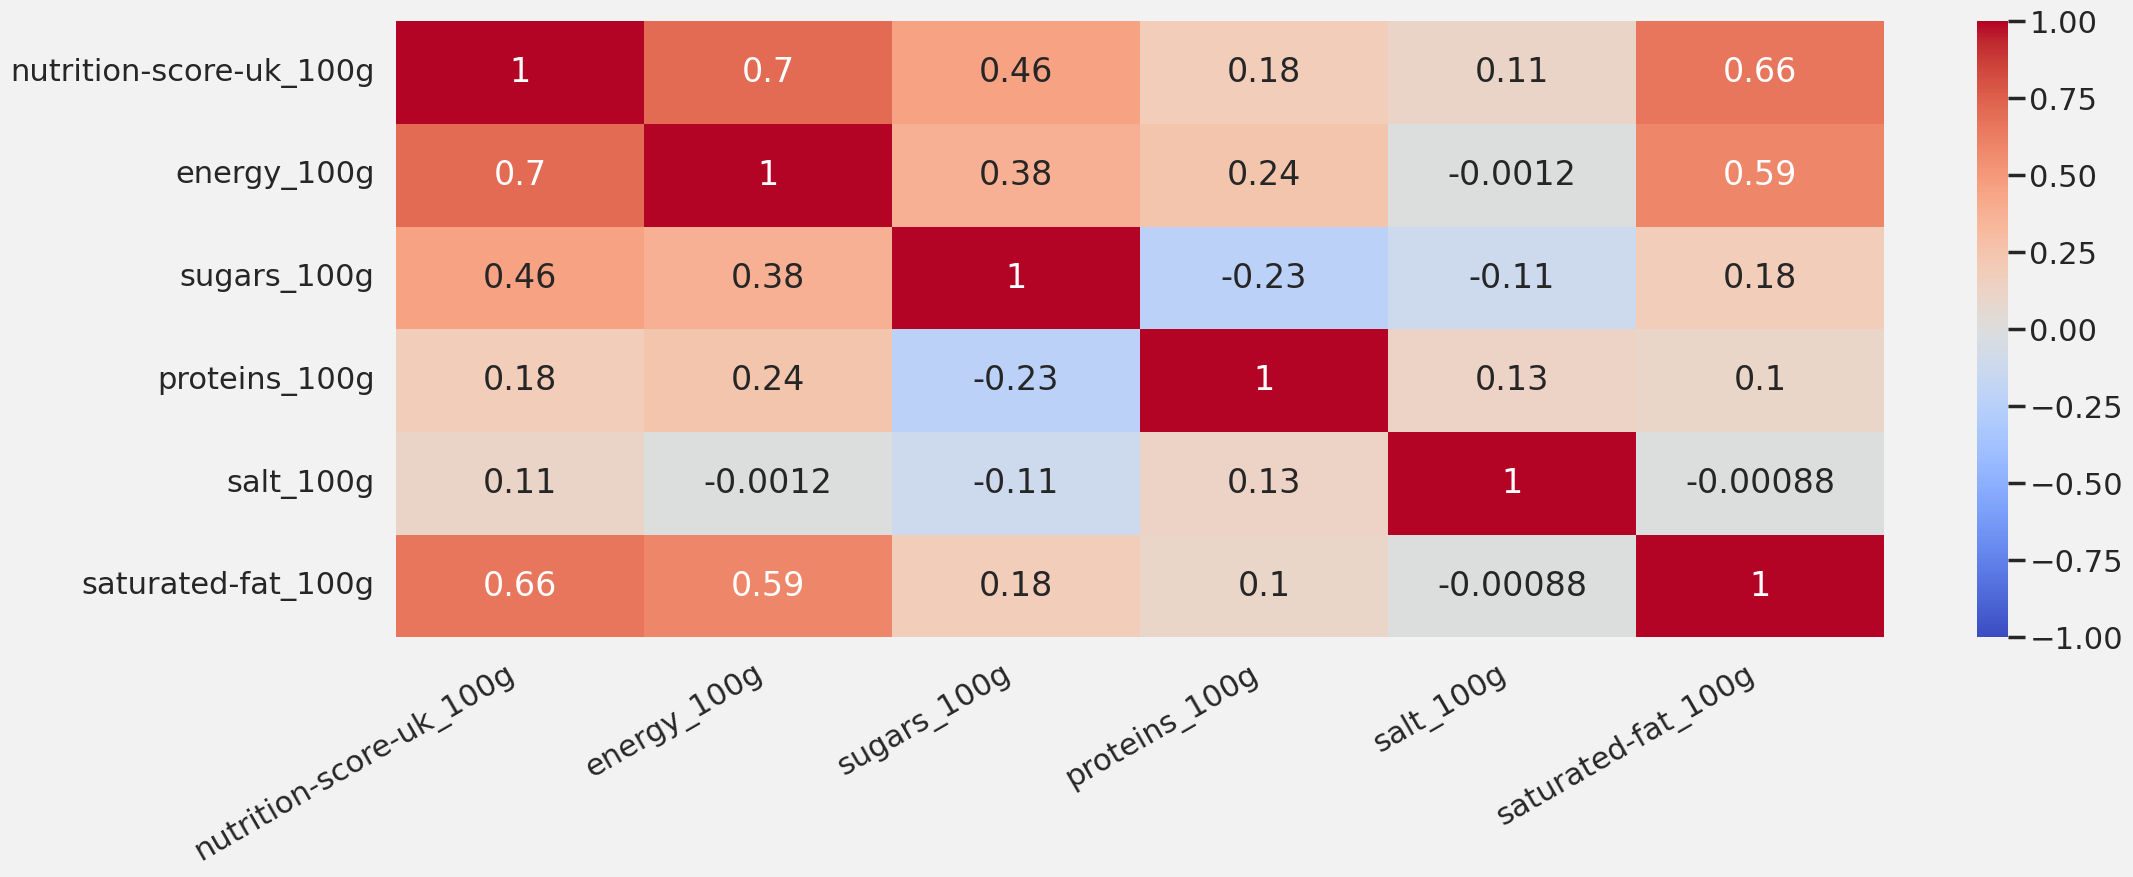

In [126]:
sns.set_context('poster')
cm = X_[[
    "nutrition-score-uk_100g",
    "energy_100g",
    "sugars_100g",
    "proteins_100g",
    "salt_100g",
    "saturated-fat_100g",
    ]].corr()

fig, ax = plt.subplots(figsize=(24, 8))
labels = ax.get_label()
sns.heatmap(cm, cmap="coolwarm", vmin=-1, annot=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='right')

plt.show()

### PCA

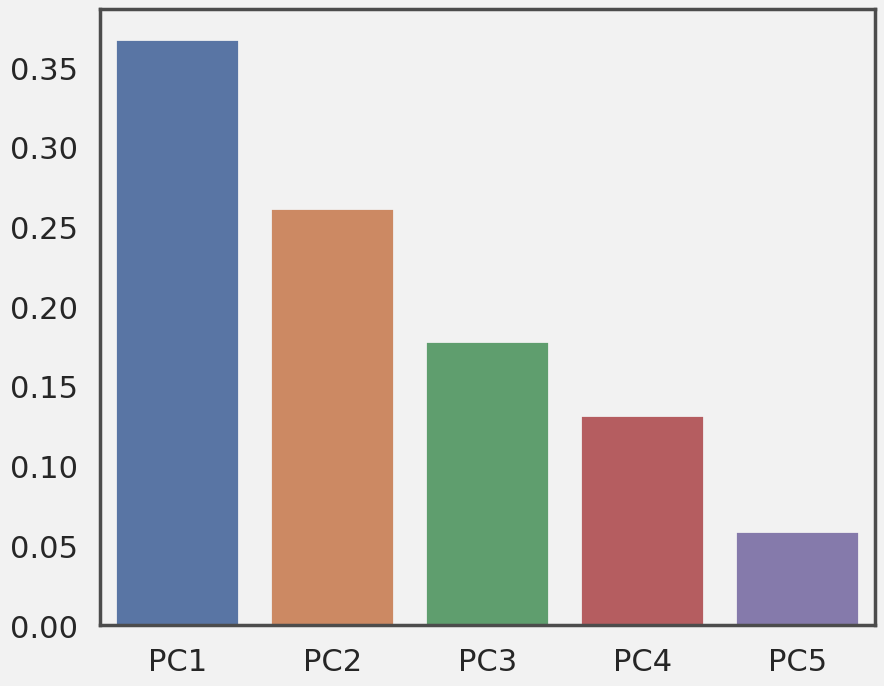

In [108]:
sns.set_context()
fig = plt.figure(figsize=(10, 8))

data = pd.concat([
    pd.DataFrame.from_dict(numerical_data_100g),
    bounded_energy,
], axis=1).dropna()

pca = PCA(n_components=len(data.columns))
X = pca.fit_transform(scale(data))

cols = [f"PC{i+1}" for i in range(X.shape[1])]

components_df = pd.DataFrame(data=X, columns=cols)

sns.barplot(x=cols, y=pca.explained_variance_ratio_)

plt.show()

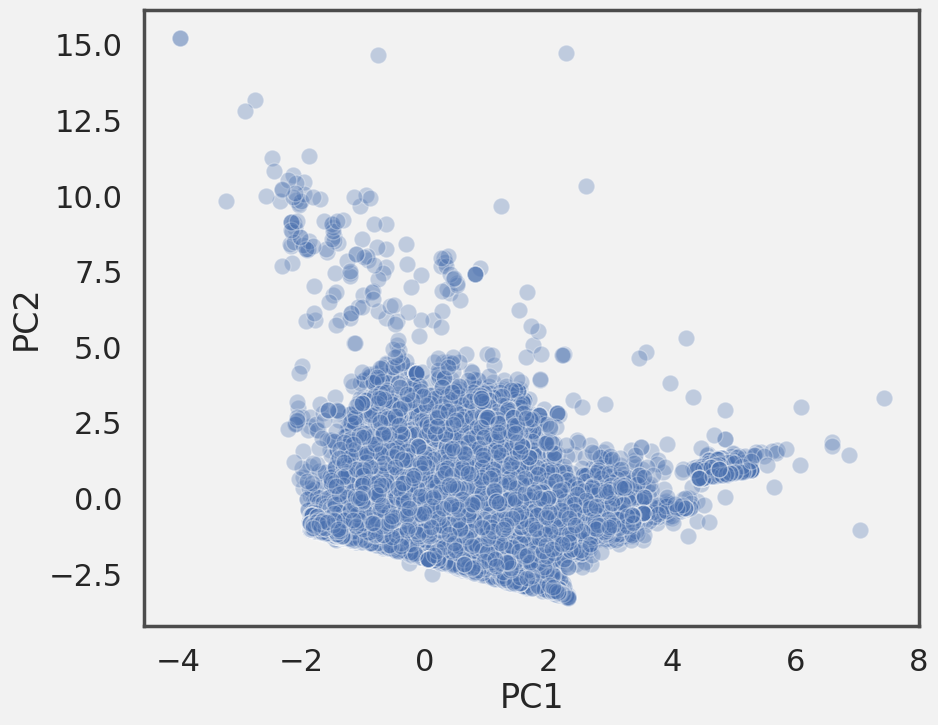

In [109]:
sns.set_context()
fig = plt.figure(figsize=(10, 8))

sns.scatterplot(x=components_df['PC1'], y=components_df['PC2'], alpha=0.3)
plt.xlabel('PC1')
plt.ylabel('PC2')

plt.show()

In [36]:
pca1 = pd.Series(pca.components_[0], index=data.columns).abs().sort_values(ascending=False)
pca2 = pd.Series(pca.components_[1], index=data.columns).abs().sort_values(ascending=False)

pd.concat([pca1, pca2], axis=1, keys=['PCA1', 'PCA2'])

,PCA1,PCA2
energy_100g,0.662575,0.145464
saturated-fat_100g,0.585622,0.175371
sugars_100g,0.457971,0.450539
salt_100g,0.069341,0.497173
proteins_100g,0.059133,0.705634


### ANOVA

In [111]:
bins = [-float('inf'), -5, 5, 15, 25, float('inf')]
group_labels = ['Less than -5', '-5 to 5', '5 to 15', '15 to 25', 'More than 25']

grouped_scores = pd.cut(
    X_['nutrition-score-uk_100g'],
    bins=bins,
    labels=group_labels,
)

dict_groups = dict()

for i, nutrition_data in enumerate(numerical_data_100g):
    groups = pd.concat([
        X_[nutrition_data].dropna(),
        grouped_scores[~X_[nutrition_data].isna()]
        ],
        axis=1,
        keys=[nutrition_data, 'grouped_scores']
    ).groupby('grouped_scores')

    dict_groups[nutrition_data] = groups.apply(lambda df: df.reset_index())[nutrition_data].unstack().T
    
    st = f_oneway(
        *[
            X_[nutrition_data][groups.groups[label]] 
            for label in group_labels
        ]
    )
    
    print(f'{nutrition_data}: \n- statistic = {st.statistic}\n- pvalue = {st.pvalue}\n')

sugars_100g: 
- statistic = 3735.7391236133526
- pvalue = 0.0

saturated-fat_100g: 
- statistic = 11155.258230525464
- pvalue = 0.0

proteins_100g: 
- statistic = 585.0120210357214
- pvalue = 0.0

salt_100g: 
- statistic = 312.203827312164
- pvalue = 6.288156181652199e-266



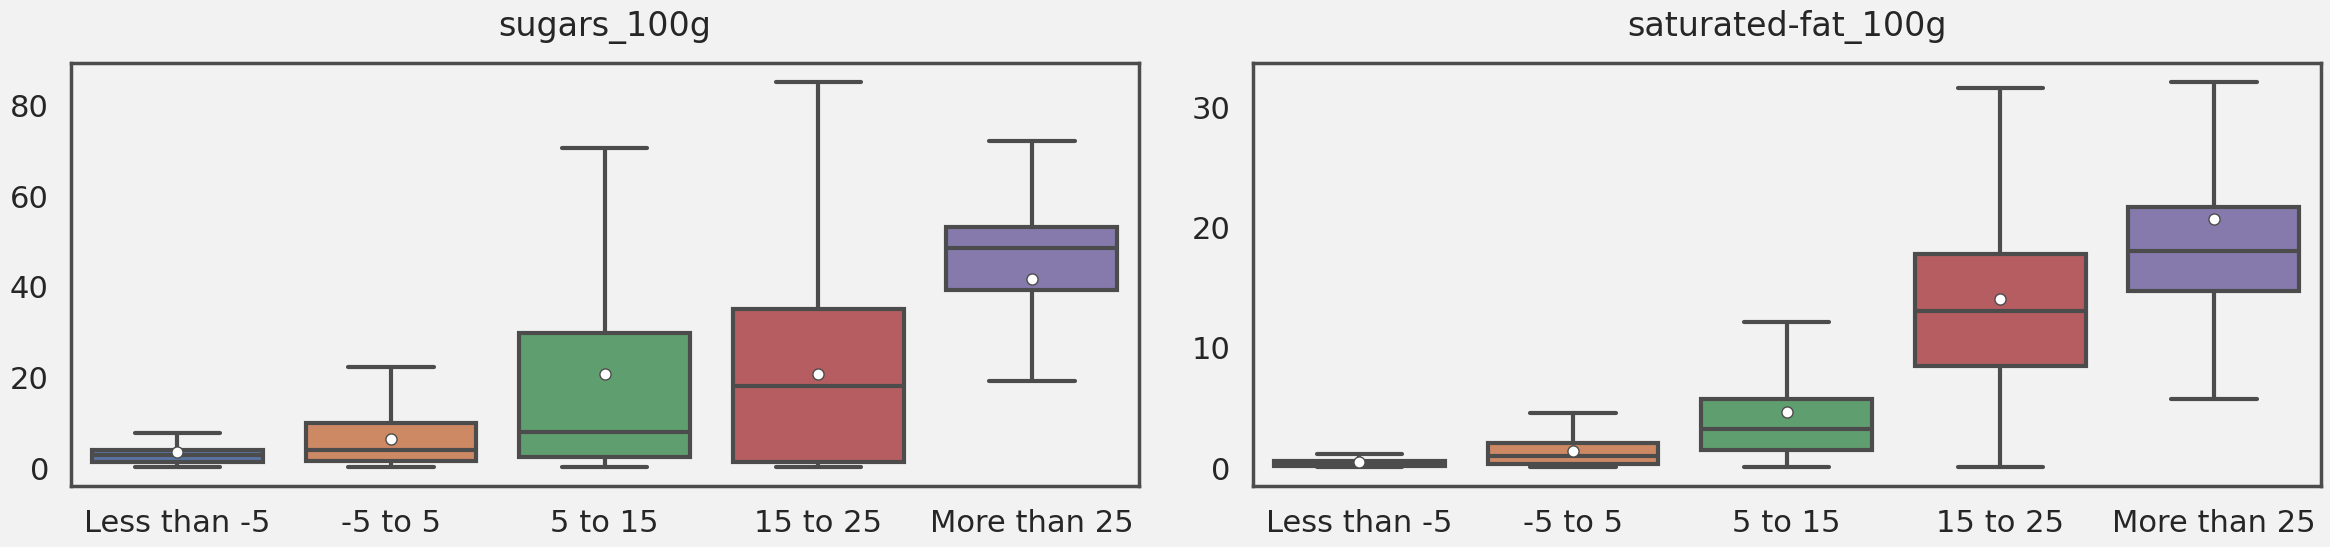

In [120]:
sns.set_context('poster')
fig = plt.figure(figsize=(24,6))

for i, key in enumerate(['sugars_100g', 'saturated-fat_100g']):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=dict_groups[key], showfliers=False, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"#4c4c4c",
                      "markersize":"8"})
    plt.xlabel('')
    plt.title(key, pad=20)

plt.tight_layout()
plt.show()

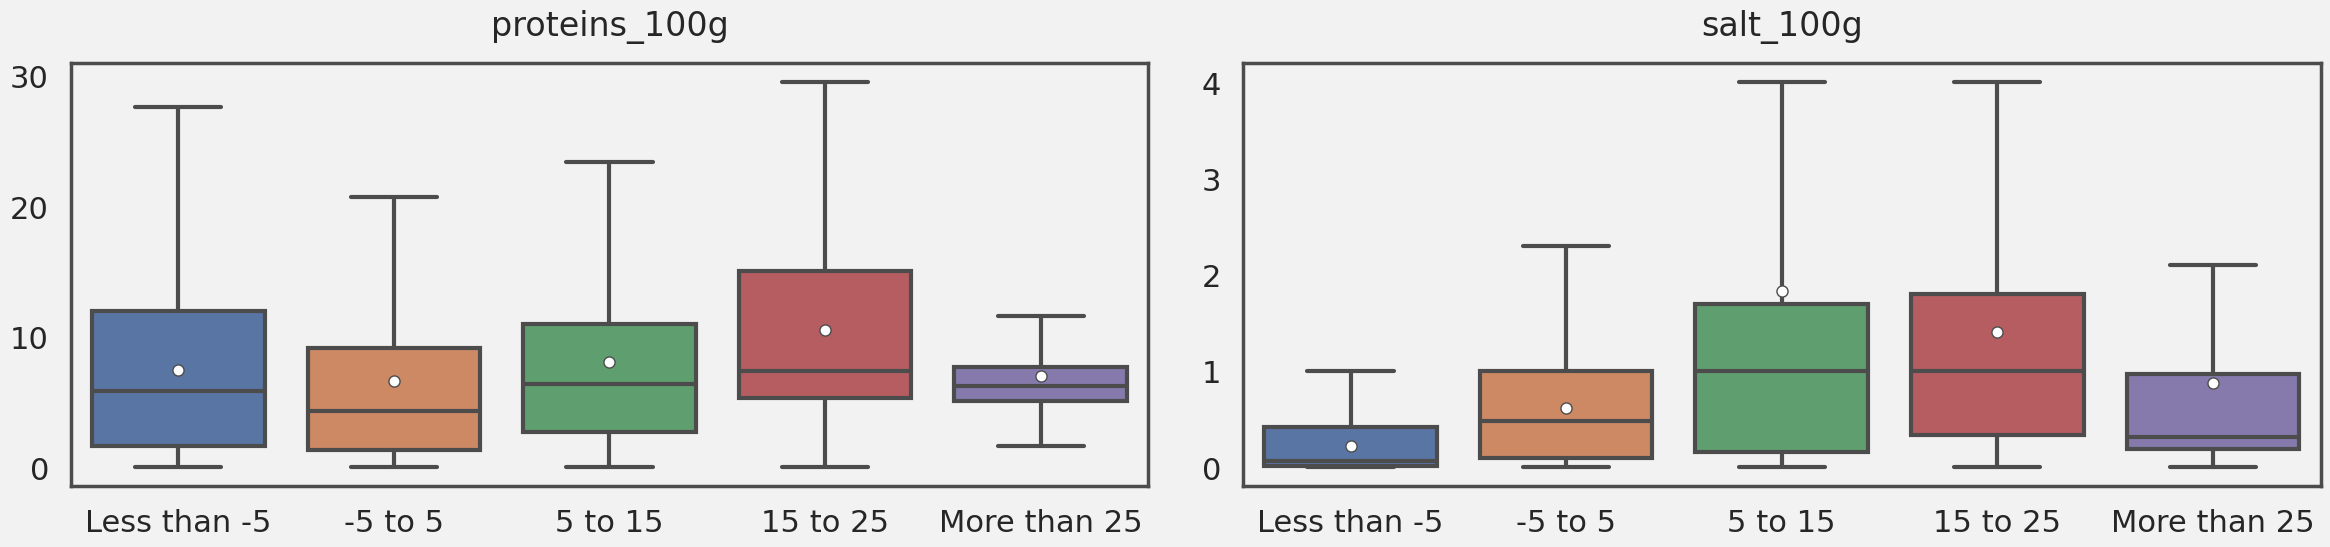

In [121]:
sns.set_context('poster')
fig = plt.figure(figsize=(24,6))

for i, key in enumerate(['proteins_100g', 'salt_100g']):
    fig.add_subplot(1, 2, i+1)
    sns.boxplot(data=dict_groups[key], showfliers=False, showmeans=True, meanprops={"marker":"o",
                       "markerfacecolor":"white", 
                       "markeredgecolor":"#4c4c4c",
                      "markersize":"8"})
    plt.xlabel('')
    plt.title(key, pad=20)

plt.tight_layout()
plt.show()